In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os
import glob
import sys
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.colors as colors
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.dates as mdates
import plotly.express as px
from matplotlib.ticker import NullFormatter
from matplotlib import rc
import seaborn as sns
import matplotlib.transforms as mtransforms
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


def ProgressBar(Total, Progress, BarLength=20, ProgressIcon="#", BarIcon="-"):
    try:
        # You can't have a progress bar with zero or negative length.
        if BarLength <1:
            BarLength = 20
        # Use status variable for going to the next line after progress completion.
        Status = ""
        # Calcuting progress between 0 and 1 for percentage.
        Progress = float(Progress) / float(Total)
        # Doing this conditions at final progressing.
        if Progress >= 1.:
            Progress = 1
            Status = "\r\n"    # Going to the next line
        # Calculating how many places should be filled
        Block = int(round(BarLength * Progress))
        # Show this
        Bar = "[{}] {:.0f}% {}".format(ProgressIcon * Block + BarIcon * (BarLength - Block), round(Progress * 100, 0), Status)
        return Bar
    except:
        return "ERROR"


def ShowBar(Bar):
    sys.stdout.write(Bar)
    sys.stdout.flush()
    
    
from scipy import signal
def cyclic_moving_av( a, n= 30, win_type= 'boxcar' ):
    # https://stackoverflow.com/questions/36074074/smooth-circular-data
  window= signal.get_window( win_type, n, fftbins=False ).reshape( (1,n) )
  shp_a= a.shape
  b= signal.convolve2d( a.reshape( ( np.prod( shp_a[:-1], dtype=int ), shp_a[-1] ) ), 
                        window, boundary='wrap', mode='same' )
  return ( b / np.sum( window ) ).reshape( shp_a )

def set_ax_date(ax, plot_type="ts"):
    # MONTHLY CLIMATOLOGY
    if plot_type == "clim":
        month_year_formatter = mdates.DateFormatter('%b') 
        monthly_locator = mdates.MonthLocator()
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    else:
        # MONTHLY WITH YEAR
        monthly_locator = mdates.MonthLocator()
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=1))
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
        ax.set_xlabel('')
        
def add_subplot_label(fig, label, fontsize='large'):
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
           fontsize=fontsize, verticalalignment='top', fontfamily='serif',
           bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    
def plot_style(plot_type="paper"):
    font_size = 22
    if plot_style == "paper":
        plt.style.use("ggplot")
        rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Roman']})
        rc('text', usetex=True)
        font_size = 14
        mpl.rcParams.update({'font.size': 22})

        mpl.rc('xtick', labelsize=16) 
        mpl.rc('ytick', labelsize=16) 
        plt.style.use("ggplot")
        mpl.rcParams["axes.edgecolor"] = [0.6, 0.6, 0.6]
        mpl.rcParams["axes.linewidth"] = 1.0
    elif plot_style == "talk":
        font_size = 22
        sns.set_context("talk")
        plt.style.use("fivethirtyeight")
        rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
        rc('text', usetex=True)
        mpl.rcParams.update({'font.size': 22})

        mpl.rc('xtick', labelsize=16) 
        mpl.rc('ytick', labelsize=16) 

        fig = plt.figure(figsize=(13.33,7.5), dpi=96)
        plt.style.use("fivethirtyeight")
        mpl.rcParams["axes.edgecolor"] = [0.6, 0.6, 0.6]
        mpl.rcParams["axes.linewidth"] = 1.0
    return font_size
    

# Create a new dataset

In [3]:
# Analysis dataset
variable_list = ['uvel','vvel','wave_sig_ht','peak_period','Tair','sst','sss','strairx','strairy','strocnx','strocny','strcorx','strcory','strtltx','strtlty','strintx','strinty','strength','divu','shear','uatm','vatm','uocn','vocn','frzmlt','daidtd','daidtt','meltt','meltb','meltl','Tsfc','sice','uatm','vatm','frazil','congel','dagedtt','dagedtd']
num_variables = np.size(variable_list)

savepath = '/home/566/nd0349/notebooks/'
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
year = 2011

NFSD = np.asarray([2.6884, 9.7984, 21.6721, 40.7349, 70.1407, 113.6938, 175.5771, 259.8365, 369.6202, 506.2401, 668.2091, 850.4769])
floe_binwidth = np.asarray([5.2438, 8.9763, 14.7711, 23.3545, 35.4569, 51.6493, 72.1173, 96.4015, 123.1658, 150.0741, 173.8638, 190.6719])

for year in tqdm(range(2010,2020)):    
    os.chdir(mypath)
    file_dates = []
    print(year)
    filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'
    
    onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
    onlyfiles.sort()
    print(filename)
    ds = xr.open_dataset(filename)
    LN = ds.TLON.values
    LT = ds.TLAT.values
    # Get the total number of grid points
    size = 1
    for dim in np.shape(LN): size *= dim
    aice_data = ds['aice'][0,:,:]
    mask1 = np.ma.masked_where(LT > 0.0, aice_data)
    mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
    master_mask = mask1.mask | mask2.mask
    mask = master_mask
    
    X_out =  np.ma.masked_array(np.empty((size,1)), mask=mask)
    
    # Loop over the files in that year
    for filecount, file in tqdm(enumerate(onlyfiles), total = len(onlyfiles),
                  desc ="Reading in data"):
        #progressBar = "\rProgress: " + ProgressBar(len(onlyfiles), filecount+1, 20, '#', '.')
        #ShowBar(progressBar)
    
        # Open the file
        filename = file
        file_dates.append(np.datetime64(file[-13:-3]))
        ds = xr.open_dataset(filename)
    
        # Get and apply masks to remove the ocean
        aice_data = ds['aice'][0,:,:]
        mask1 = np.ma.masked_where(LT > 0.0, aice_data)
        mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
        master_mask = mask1.mask | mask2.mask
        mask = master_mask
    
        # Get all the variables
        for counter, exp in enumerate(variable_list):
            data = ds[exp][0,:,:]
            data_masked = np.ma.masked_where(mask, data)
            data_masked_vec = data_masked.compressed()
            row_length, = data_masked_vec.shape
    
            if counter == 0: 
                # First file, then initialise X_temp
                X_single_file = data_masked_vec.reshape(row_length,1)
            else:
                # Else just concatenate the new data on
                X_single_file = np.concatenate([X_single_file, data_masked_vec.reshape(row_length,1)],axis=1)
    
        
        
        # Add on the corresponding coordinates
        LN_masked = np.ma.masked_where(mask, LN)
        LN_vec = LN_masked.compressed()
        LT_masked = np.ma.masked_where(mask, LT)
        LT_vec = LT_masked.compressed()
        X_single_file = np.concatenate([X_single_file, LN_vec.reshape(row_length,1), LT_vec.reshape(row_length,1)],axis=1)
    
        if filecount == 0: 
            # Day 1, then initialise the year file
            X_year = X_single_file
            datetime_vec =  np.tile(np.datetime64(file[-13:-3]),(row_length,1))
        else:
            X_year = np.concatenate([X_year, X_single_file],axis=0)
            datetime_vec = np.concatenate([datetime_vec, np.tile(np.datetime64(file[-13:-3]),(row_length,1))],axis=0)
    # Save as dataframe
    df_raw = pd.DataFrame(X_year, columns = variable_list+['longitude','latitude'])#,'date'])
    df_raw['date'] = datetime_vec
    print(datetime_vec.shape)
    df_raw = df_raw.dropna()
    
    savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
    savefilename = 'forcing_analysis_'+str(year)+'.csv'
    df_raw.to_csv(savepath+savefilename)

  0%|          | 0/10 [00:00<?, ?it/s]

2010
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2010-01-01.nc



Reading in data: 100%|██████████| 365/365 [03:56<00:00,  1.54it/s]


(6814189, 1)


 10%|█         | 1/10 [04:58<44:43, 298.20s/it]

2011
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2011-01-01.nc



Reading in data: 100%|██████████| 365/365 [03:58<00:00,  1.53it/s]


(6748512, 1)


 20%|██        | 2/10 [09:57<39:50, 298.78s/it]

2012
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2012-01-01.nc



Reading in data: 100%|██████████| 366/366 [04:06<00:00,  1.49it/s]


(6804832, 1)


 30%|███       | 3/10 [15:08<35:29, 304.20s/it]

2013
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2013-01-01.nc



Reading in data: 100%|██████████| 365/365 [03:59<00:00,  1.53it/s]


(6849043, 1)


 40%|████      | 4/10 [20:15<30:33, 305.53s/it]

2014
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2014-01-01.nc



Reading in data: 100%|██████████| 365/365 [04:00<00:00,  1.52it/s]


(6856148, 1)


 50%|█████     | 5/10 [25:22<25:29, 305.85s/it]

2015
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2015-01-01.nc



Reading in data: 100%|██████████| 365/365 [03:58<00:00,  1.53it/s]


(6866149, 1)


 60%|██████    | 6/10 [30:24<20:18, 304.55s/it]

2016
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2016-01-01.nc



Reading in data: 100%|██████████| 366/366 [04:01<00:00,  1.52it/s]


(6779432, 1)


 70%|███████   | 7/10 [35:25<15:10, 303.47s/it]

2017
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2017-01-01.nc



Reading in data: 100%|██████████| 365/365 [03:33<00:00,  1.71it/s]


(6674395, 1)


 80%|████████  | 8/10 [39:55<09:45, 292.92s/it]

2018
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2018-01-01.nc



Reading in data: 100%|██████████| 365/365 [03:42<00:00,  1.64it/s]


(6771169, 1)


 90%|█████████ | 9/10 [44:38<04:49, 289.82s/it]

2019
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2019-01-01.nc



Reading in data: 100%|██████████| 365/365 [03:44<00:00,  1.63it/s]


(6734811, 1)


100%|██████████| 10/10 [49:22<00:00, 296.26s/it]


In [5]:
df_raw.describe()

,uvel,vvel,wave_sig_ht,peak_period,Tair,sst,sss,strairx,strairy,strocnx,...,Tsfc,sice,uatm,vatm,frazil,congel,dagedtt,dagedtd,longitude,latitude
count,2.149411e+06,2.149411e+06,2.149411e+06,2.149411e+06,2.149411e+06,2.149411e+06,2.149411e+06,2.149411e+06,2.149411e+06,2.149411e+06,...,2.149411e+06,2.149411e+06,2.149411e+06,2.149411e+06,2.149411e+06,2.149411e+06,2.149411e+06,2.149411e+06,2.149411e+06,2.149411e+06
mean,2.382262e-02,2.068933e-02,8.036611e-02,1.143277e+01,-1.132757e+01,-1.884133e+00,3.409512e+01,1.651438e-02,1.083252e-02,-1.808382e-02,...,-1.253529e+01,7.674662e+00,9.102778e-01,7.731110e-01,2.348424e-01,4.973112e-01,-2.130987e-01,-8.984504e-02,2.044955e+02,-6.847778e+01
std,1.391237e-01,9.484623e-02,3.484221e-01,1.274795e+01,8.655896e+00,2.622920e-01,4.455293e-01,1.682706e-01,1.258635e-01,1.568031e-01,...,9.096383e+00,3.799274e+00,6.394348e+00,5.057195e+00,4.571393e-01,6.236457e-01,1.516958e+01,6.126256e+00,1.006169e+02,5.043830e+00
min,-7.570149e-01,-4.848019e-01,0.000000e+00,0.000000e+00,-3.694925e+01,-1.968343e+00,2.746605e+01,-2.359299e+00,-1.412029e+00,-1.247689e+00,...,-4.545835e+01,1.033258e+00,-3.439929e+01,-2.589948e+01,0.000000e+00,0.000000e+00,-5.567318e+02,-1.935908e+03,5.000000e-01,-7.762990e+01
25%,-5.477593e-02,-3.319645e-02,6.157348e-10,9.740626e+00,-1.775526e+01,-1.926522e+00,3.391389e+01,-3.659634e-02,-3.178424e-02,-7.512137e-02,...,-1.955459e+01,5.089177e+00,-3.088956e+00,-2.365215e+00,2.027169e-02,2.178430e-02,-3.245337e-01,-6.872358e-01,1.485000e+02,-7.279180e+01
50%,1.489052e-02,1.887188e-02,3.019877e-05,1.474219e+01,-1.041017e+01,-1.911729e+00,3.413337e+01,1.140025e-02,8.311805e-03,-8.444146e-03,...,-1.149400e+01,6.583663e+00,1.252706e+00,1.036898e+00,1.018791e-01,3.055027e-01,-1.550379e-01,-2.075876e-02,2.085000e+02,-6.870660e+01
75%,1.102547e-01,7.797734e-02,5.976489e-03,1.479290e+01,-3.275124e+00,-1.898409e+00,3.438134e+01,8.460179e-02,5.665721e-02,2.751179e-02,...,-4.126013e+00,8.834165e+00,5.332166e+00,4.054595e+00,2.711442e-01,7.243450e-01,-2.899515e-02,5.480713e-01,3.035000e+02,-6.444659e+01
max,5.661815e-01,5.987123e-01,9.020516e+00,9.999969e+02,1.830265e+00,4.728576e+00,3.509861e+01,1.252629e+00,1.717917e+00,2.240060e+00,...,1.130448e-07,3.077429e+01,2.639814e+01,2.823955e+01,1.230437e+01,6.478444e+00,8.933545e+03,1.467925e+02,3.595000e+02,-5.385874e+01


# Read in data

In [2]:
# Read in data 
year = 2019
df = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/forcing_analysis_'+str(year)+'.csv')
df_kmeans = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/kmeans_'+str(year)+'.csv')
df['k'] = df_kmeans['k']
unique_dates = df['date'].unique()
df.groupby('k').head()

,Unnamed: 0,uvel,vvel,wave_sig_ht,peak_period,Tair,sst,sss,strairx,strairy,...,uatm.1,vatm.1,frazil,congel,dagedtt,dagedtd,longitude,latitude,date,k
0,564,0.000287,0.000245,2.795573e-06,14.792899,-2.932935,-1.781372,32.978620,0.004575,0.004824,...,1.328566,1.468707,0.0,0.000000,0.006943,-0.000016,312.5,-77.62990,2019-01-01,2
1,565,0.001050,0.000680,6.634011e-07,14.792899,-3.246090,-1.803330,33.393150,0.004521,0.004798,...,1.491019,1.661607,0.0,0.000000,-0.084499,-0.028457,313.5,-77.62990,2019-01-01,2
2,566,0.003573,0.001776,1.655079e-09,12.327416,-3.698683,-1.809941,33.599583,0.004884,0.005882,...,1.593325,1.818161,0.0,0.000000,-0.113859,-0.048187,314.5,-77.62990,2019-01-01,2
3,567,0.015476,0.008362,2.595775e-09,6.780079,-4.144099,-1.806151,33.695873,0.006142,0.009243,...,1.614328,2.084585,0.0,0.000000,-0.107019,-0.099329,315.5,-77.62990,2019-01-01,2
4,568,0.033324,0.023088,5.727910e-07,9.245562,-4.571921,-1.793291,33.722122,0.008352,0.014897,...,1.629338,2.490803,0.0,0.000000,-0.090568,-0.142636,316.5,-77.62990,2019-01-01,2
1064,6155,-0.049151,0.005366,3.100281e-01,12.285270,-4.384114,-1.415815,32.433254,0.000232,0.000463,...,0.122311,2.082268,0.0,0.001707,0.375752,0.004728,272.5,-72.79180,2019-01-01,0
1177,6483,-0.043230,0.000639,2.283241e-01,13.365038,-3.021691,-1.731131,32.476902,-0.001025,0.001090,...,-0.978318,1.936207,0.0,0.000000,0.081586,0.229432,267.5,-72.43740,2019-01-01,1
1178,6484,-0.050063,-0.004166,3.412518e-01,12.398359,-2.925818,-1.741353,32.621212,0.000086,0.000770,...,-0.130267,1.900084,0.0,0.000000,0.089217,0.271236,268.5,-72.43740,2019-01-01,0
1179,6485,-0.051449,-0.011832,4.068594e-01,11.963228,-3.304626,-1.736713,32.649113,0.000344,0.000594,...,0.438094,1.867939,0.0,0.000000,0.167992,0.236994,269.5,-72.43740,2019-01-01,0
1180,6486,-0.052843,-0.011846,4.619969e-01,11.647817,-4.106879,-1.642674,32.706436,0.000246,0.000264,...,0.853754,1.872553,0.0,0.000000,0.608131,0.149811,270.5,-72.43740,2019-01-01,0


# Stresses

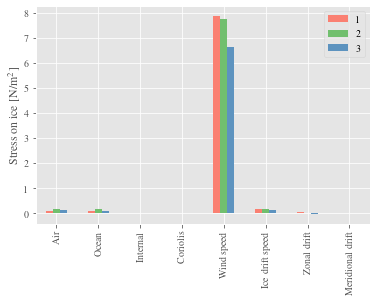

In [3]:
# create DataFrame
plt.style.use("ggplot")
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

df_magnitude = pd.DataFrame({'k': df["k"].values,
                             "date": df["date"].values,
                             "strair": np.sqrt(np.square(df["strairx"])+np.square(df["strairy"])),
                             "strocn": np.sqrt(np.square(df["strocnx"])+np.square(df["strocny"])),
                             "strint": np.sqrt(np.square(df["strintx"])+np.square(df["strinty"])),
                             "strcor": np.sqrt(np.square(df["strcorx"])+np.square(df["strcory"])),
                             "wind_speed": np.sqrt(np.square(df["uatm"])+np.square(df["vatm"])),
                             "ice_speed": np.sqrt(np.square(df["uvel"])+np.square(df["vvel"])),
                             "uvel": df["uvel"],
                             "vvel": df["vvel"],
                            })
                             
#df_magnitude["strair"] = np.sqrt(np.square(df["strairx"])+np.square(df["strairy"]))
#df_magnitude["strocn"] = np.sqrt(np.square(df["strairx"])+np.square(df["strairy"]))


df_grouped = df_magnitude[["strair", "strocn", "strint", "strcor", "wind_speed", "ice_speed", "uvel", "vvel", "k"]].groupby('k').mean(numeric_only=True)
#df_grouped["dafsd_latm"] = df_grouped["dafsd_latm"]*100#.values*(10^5)
#df_grouped["dafsd_latg"] = df_grouped["dafsd_latg"]*10000


df_plot = pd.DataFrame({'1': df_grouped.iloc[0,:].values,
                        '2': df_grouped.iloc[1,:].values,
                        '3': df_grouped.iloc[2,:].values},
                        index=['Air', 'Ocean', 'Internal', 'Coriolis', 'Wind speed', 'Ice drift speed', 'Zonal drift', 'Meridional drift'])
 
 
# create stacked bar chart for monthly temperatures
#df_plot.plot(kind='bar', stacked=True, color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
ax = df_plot.plot.bar(color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#plt.xticks(range(3),['Shear ($10^{1}$)','Divergence','Strength ($10^{4}$)'])

# labels for x & y axis
#plt.xlabel('Floe size mechanisms')
plt.ylabel('Stress on ice [N/m$^2$]')
 
# title of plot
#plt.title('Monthly Temperatures in a year')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'stresses_bar.png', dpi = 600, bbox_inches="tight")

In [34]:
# Timeseries data
df_magnitude['date'] = pd.to_datetime(df_magnitude['date'], format="%Y-%m-%d")
df_timeseries = df_magnitude.groupby(['date', 'k']).rolling(7).mean(numeric_only=True)
df_timeseries_stress = df_timeseries
df_timeseries_stress

strair    strocn    strint    strcor  wind_speed  \
date       k                                                               
2019-01-01 0 1064          NaN       NaN       NaN       NaN         NaN   
             1178          NaN       NaN       NaN       NaN         NaN   
             1179          NaN       NaN       NaN       NaN         NaN   
             1180          NaN       NaN       NaN       NaN         NaN   
             1287          NaN       NaN       NaN       NaN         NaN   
...                        ...       ...       ...       ...         ...   
2019-12-31 2 2104564  0.067649  0.066649  0.000143  0.012222    6.519492   
             2104565  0.066888  0.065904  0.000131  0.012044    6.511171   
             2104566  0.066575  0.065605  0.000129  0.011883    6.526947   
             2104567  0.066646  0.065687  0.000135  0.011777    6.571618   
             2104568  0.066862  0.065918  0.000138  0.011711    6.644279   

                      ice_speed      uvel      vvel  
date       k                                         
2019-01-01 0 1064           NaN       NaN       NaN  
             1178           NaN       NaN       NaN  
             1179           NaN       NaN       NaN  
             1180           NaN       NaN       NaN  
             1287           NaN       NaN       NaN  
...                         ...       ...       ...  
2019-12-31 2 2104564   0.154608 -0.053926 -0.143863  
             2104565   0.152723 -0.047010 -0.144309  
             2104566   0.151282 -0.040209 -0.145065  
             2104567   0.150720 -0.033800 -0.146413  
             2104568   0.151132 -0.027837 -0.148297  

[2104612 rows x 8 columns]

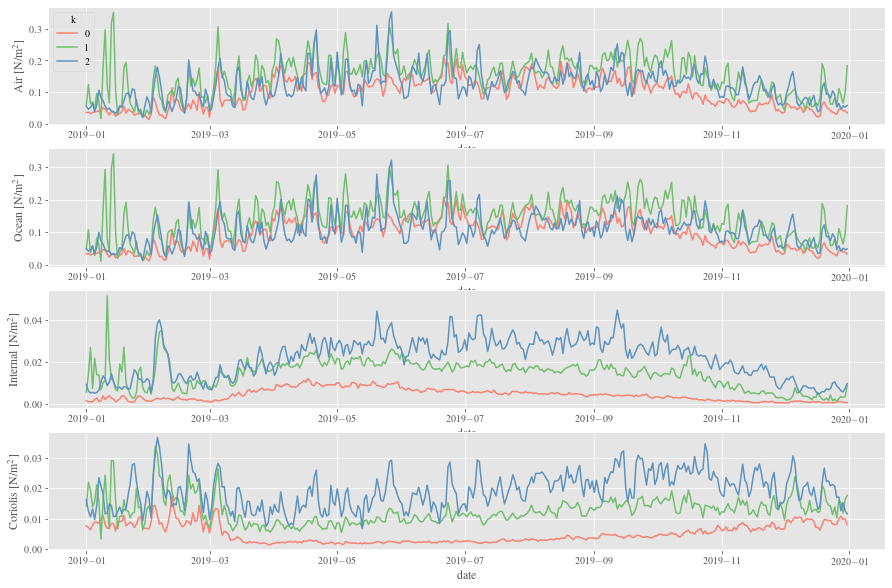

In [8]:
# Time series plot
plt.style.use("ggplot")
#sns.set_context("talk")
# set figure size
#plt.figure(figsize=(12,6))
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharey=False)
#fig.suptitle('Initial Pokemon - 1st Generation')


# Time series plot with Seaborn lineplot()
sns.lineplot(ax=axes[0], x="date", y="strair", hue="k",
            data=df_timeseries, errorbar=None,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[0].set(ylabel='Air [N/m$^2$]')

sns.lineplot(ax=axes[1], x="date", y="strocn", hue="k",
            data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[1].set(ylabel='Ocean [N/m$^2$]')

sns.lineplot(ax=axes[2], x="date", y="strint", hue="k",
            data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[2].set(ylabel='Internal [N/m$^2$]')
    
sns.lineplot(ax=axes[3], x="date", y="strcor", hue="k",
            data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[3].set(ylabel='Coriolis [N/m$^2$]')


plt.savefig(savepath+'stresses_ts.png', dpi = 600, bbox_inches="tight")

# Dynamics

In [4]:
# Dynamics

# create DataFrame
plt.style.use("ggplot")
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

df_dyn = pd.DataFrame({'k': df["k"].values,
                             "date": df["date"].values,
                             "uvel": df["uvel"].values,
                             "vvel": df["vvel"].values,
                             "uatm": df["uatm"].values,
                             "vatm": df["vatm"].values,
                             "atm": np.sqrt(np.square(df["uatm"])+np.square(df["vatm"])),
                             "vel": np.sqrt(np.square(df["uvel"])+np.square(df["vvel"])),
                             "shear": df["shear"].values,
                             "divu": df["divu"].values,
                             "strength": df["strength"].values,
                             "strint": np.sqrt(np.square(df["strintx"])+np.square(df["strinty"])),
                             "strair": np.sqrt(np.square(df["strairx"])+np.square(df["strairy"])),
                            })
                             
#df_magnitude["strair"] = np.sqrt(np.square(df["strairx"])+np.square(df["strairy"]))
#df_magnitude["strocn"] = np.sqrt(np.square(df["strairx"])+np.square(df["strairy"]))


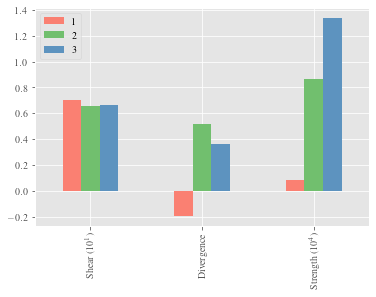

In [10]:
df_grouped = df_dyn[["shear", "divu", "strength", "k"]].groupby('k').mean(numeric_only=True)
#df_grouped["dafsd_latm"] = df_grouped["dafsd_latm"]*100#.values*(10^5)
#df_grouped["dafsd_latg"] = df_grouped["dafsd_latg"]*10000
df_grouped['shear'] = df_grouped['shear']*0.1
df_grouped['strength'] = df_grouped['strength']*0.0001

df_plot = pd.DataFrame({'1': df_grouped.iloc[0,:].values,
                        '2': df_grouped.iloc[1,:].values,
                        '3': (df_grouped.iloc[2,:].values)},
                        index=['shear', 'divu', 'strength'])
 
 
# create stacked bar chart for monthly temperatures
#df_plot.plot(kind='bar', stacked=True, color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
ax = df_plot.plot.bar(color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
plt.xticks(range(3),['Shear ($10^{1}$)','Divergence','Strength ($10^{4}$)'])

#plt.ylabel('Ice velocity [m/s]')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'dyn_shear_bar.png', dpi = 600, bbox_inches="tight")

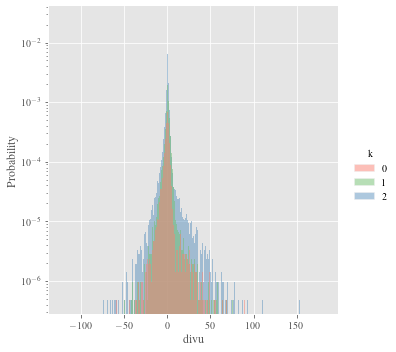

In [22]:
sns.displot(data=df_dyn, x="divu", hue="k", stat="probability",
            palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
plt.yscale('log')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'div_bar.png', dpi = 600, bbox_inches="tight")

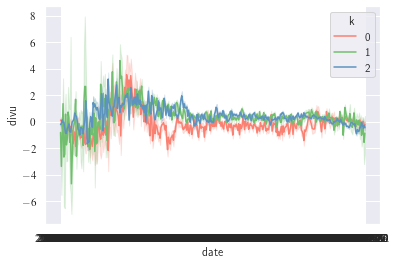

In [26]:
df_dyn['date'] = pd.to_datetime(df_dyn['date'], format="%Y-%m-%d")
sns.lineplot(data=df_dyn, x="date", hue="k", y="divu",
            palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#plt.yscale('log')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'div_ts.png', dpi = 600, bbox_inches="tight")

In [25]:
df_dyn

,k,date,uvel,vvel,uatm,vatm,vel,shear,divu,strength
0,2,2019-01-01,0.000287,0.000245,1.328566,1.468707,0.000377,0.007471,0.007066,35160.420000
1,2,2019-01-01,0.001050,0.000680,1.491019,1.661607,0.001250,0.019325,0.013172,17397.049000
2,2,2019-01-01,0.003573,0.001776,1.593325,1.818161,0.003990,0.054595,0.024171,13628.646000
3,2,2019-01-01,0.015476,0.008362,1.614328,2.084585,0.017590,0.199661,0.109697,8048.901400
4,2,2019-01-01,0.033324,0.023088,1.629338,2.490803,0.040540,0.460898,0.196870,4122.779300
...,...,...,...,...,...,...,...,...,...,...
2104607,0,2019-12-31,0.030783,-0.150848,-0.566998,-7.149548,0.153957,4.923363,0.125220,0.002186
2104608,0,2019-12-31,0.029972,-0.153799,-0.679548,-7.368905,0.156693,5.020710,0.420263,0.004014
2104609,0,2019-12-31,0.032391,-0.156800,-0.669136,-7.528142,0.160110,5.141208,0.785161,0.005150
2104610,0,2019-12-31,0.038248,-0.158241,-0.429035,-7.645956,0.162797,5.370617,1.045927,0.003491


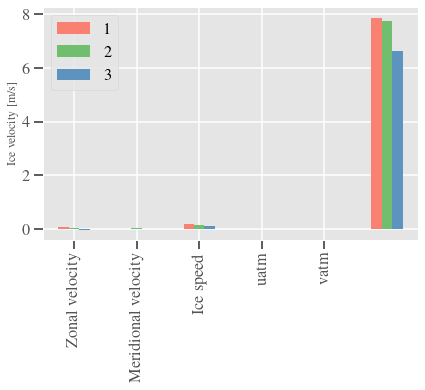

In [43]:

df_grouped = df_dyn[["uvel", "vvel", "vel","uatm","vatm","atm", "k"]].groupby('k').mean(numeric_only=True)
df_grouped["uatm"] = df_grouped["uatm"].values*(0.01)
df_grouped["vatm"] = df_grouped["vatm"].values*(0.01)
#df_grouped["dafsd_latm"] = df_grouped["dafsd_latm"]*100#.values*(10^5)
#df_grouped["dafsd_latg"] = df_grouped["dafsd_latg"]*10000


df_plot = pd.DataFrame({'1': df_grouped.iloc[0,:].values,
                        '2': df_grouped.iloc[1,:].values,
                        '3': df_grouped.iloc[2,:].values},
                        index=['uvel', 'vvel', 'vel', 'uatm', 'vatm', 'atm'])
 
 
# create stacked bar chart for monthly temperatures
#df_plot.plot(kind='bar', stacked=True, color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
ax = df_plot.plot.bar(color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
plt.xticks(range(5),['Zonal velocity','Meridional velocity','Ice speed', 'uatm', 'vatm'])

# labels for x & y axis
#plt.xlabel('Floe size mechanisms')
plt.ylabel('Ice velocity [m/s]')
 
# title of plot
#plt.title('Monthly Temperatures in a year')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'velocity_bar.png', dpi = 600, bbox_inches="tight")

In [58]:
df_dyn['date'] = pd.to_datetime(df_dyn['date'], format="%Y-%m-%d")
df_timeseries = df_dyn.groupby(['date', 'k']).rolling(7).mean(numeric_only=True)

In [ ]:
# Time series plot
plt.style.use("ggplot")
#sns.set_context("talk")
#plt.figure(figsize=(12,6))
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharey=False)
#fig.suptitle('Initial Pokemon - 1st Generation')

# Time series plot with Seaborn lineplot()

sns.lineplot(ax=axes[0], x="date", y="uvel", hue="k",
             data=df_timeseries, errorbar=None,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[0].set(ylabel='uvel []')
#axes[0].set_title('Horizontal veloci')

sns.lineplot(ax=axes[1], x="date", y="vvel", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[1].set(ylabel='vvel []')
# #axes[1].set_ylim((-0.1,0.1))

sns.lineplot(ax=axes[2], x="date", y="uatm", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[2].set(ylabel='uatm []')

sns.lineplot(ax=axes[3], x="date", y="vatm", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[3].set(ylabel='vatm []')
#axes[2].set_ylim((0,0.25))
#axes[2].set_title('Internal')
    
#axes[2].set_ylim((0,0.1))
# axis labels
#plt.xlabel("Date", size=14)
#plt.ylabel("Daily New Cases", size=14)
# save image as PNG file

#df_magnitude
#plt.savefig(savepath+'dynamics_ts.png', dpi = 600, bbox_inches="tight")



KeyboardInterrupt



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x14fd26f2f1f0> (for post_execute):


In [132]:
# Timeseries data
df_dyn['date'] = pd.to_datetime(df_dyn['date'], format="%Y-%m-%d")
idx = (df_dyn['k'].values == 2)
df_temp = df_dyn

temp_vec = df_temp['k'].values
temp_vec[idx] = 1
df_temp['k'] = temp_vec


df_interior = pd.DataFrame({'k': df_temp["k"].astype("category").values,
                            'date': df_temp["date"].values,
                            'atm': df_temp["atm"].values,
                            'vel': df_temp["vel"].values,
                            'strair': df_temp["strair"].values,
                            'strint': df_temp["strint"].values,
                           }
                          )

#df_interior = df_dyn[['k','date','atm']] # , dtype="category")
#df_interior['k'] = df_interior["k"].astype("category").values
df_interior
#df_interior['k'] = str(df_interior['k'])

#df_interior['atm'] = df_temp.groupby(['k', 'date']).rolling(10)['atm'].mean().droplevel(level=[1])
#df_interior['vel'] = df_temp.groupby(['k', 'date']).rolling(10)['vel'].mean().droplevel(level=[1])
#df_interior['strair'] = df_temp.groupby(['k', 'date']).rolling(10)['strair'].mean().droplevel(level=[1])
#df_interior['strint'] = df_temp.groupby(['k', 'date']).rolling(10)['atm'].strint().droplevel(level=[1])


,k,date,atm,vel,strair,strint
0,1,2019-01-01,1.980452,0.000377,0.006648,1.278263e-02
1,1,2019-01-01,2.232504,0.001250,0.006593,8.342592e-03
2,1,2019-01-01,2.417518,0.003990,0.007646,8.407972e-03
3,1,2019-01-01,2.636579,0.017590,0.011097,1.187948e-02
4,1,2019-01-01,2.976380,0.040540,0.017079,1.711179e-02
...,...,...,...,...,...,...
2104607,0,2019-12-31,7.171996,0.153957,0.017363,1.752612e-08
2104608,0,2019-12-31,7.400172,0.156693,0.021783,1.409631e-08
2104609,0,2019-12-31,7.557821,0.160110,0.022808,8.772226e-09
2104610,0,2019-12-31,7.657984,0.162797,0.019046,2.700619e-09


In [8]:
df_dyn['date'] = pd.to_datetime(df_dyn['date'], format="%Y-%m-%d")
idx = (df_dyn['k'].values == 2)
df_temp = df_dyn
df_temp['vel_frac'] = df_dyn['vel'].values/df_dyn['atm'].values

temp_vec = df_temp['k'].values
temp_vec[idx] = 1
df_temp['k'] = temp_vec


idx = (df_temp['k'].values == 0)
df_MIZ = df_temp.iloc[idx,:]
#print(df_MIZ)

idx = (df_temp['k'].values == 1)
df_interior = df_temp.iloc[idx,:]
#print(df_interior)


In [ ]:
df_MIZ['date']  = pd.to_datetime(df_MIZ['date'], format="%Y-%m-%d")
df_interior['date']  = pd.to_datetime(df_interior['date'], format="%Y-%m-%d")
df_timeseries_MIZ = df_MIZ.groupby(['date']).mean()
df_timeseries = df_interior.groupby(['date']).mean()
df_timeseries_MIZ = df_timeseries_MIZ.rolling(7).mean()
df_timeseries = df_timeseries.rolling(7).mean()
df_timeseries

df_ts = pd.DataFrame({'date': pd.date_range(start="2019-01-01",end="2019-12-31"),
                      'atm_miz': df_timeseries_MIZ["atm"].values,
                      'atm_interior': df_timeseries["atm"].values,
                      'vel_miz': df_timeseries_MIZ["vel"].values,
                      'vel_interior': df_timeseries["vel"].values,
                      'strair_miz': df_timeseries_MIZ["strair"].values,
                      'strair_interior': df_timeseries["strair"].values,
                      'strint_miz': df_timeseries_MIZ["strint"].values,
                      'strint_interior': df_timeseries["strint"].values,
                      'vel_frac_miz': df_timeseries_MIZ["vel_frac"].values,
                      'vel_frac_interior': df_timeseries["vel_frac"].values,
                           }
                          )
#df_timeseries['date'] = pd.to_datetime(df_interior['date'].unique(), format="%Y-%m-%d")

/jobfs/89204051.gadi-pbs/ipykernel_223391/2522811495.py:94: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(ax=ax, x="date", y="strair_interior",
/jobfs/89204051.gadi-pbs/ipykernel_223391/2522811495.py:97: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(ax=ax, x="date", y="strair_miz",
/jobfs/89204051.gadi-pbs/ipykernel_223391/2522811495.py:109: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(ax=ax, x="date", y="strint_interior",
/jobfs/89204051.gadi-pbs/ipykernel_223391/2522811495.py:112: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(ax=ax, x="date", y="strint_miz",


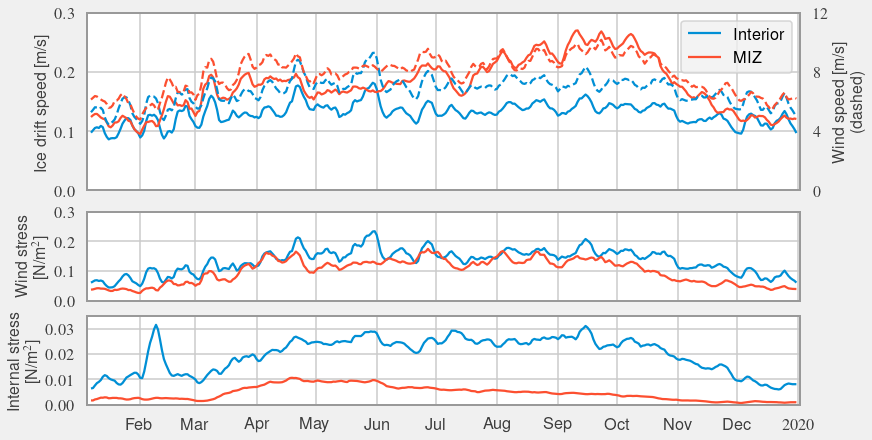

In [77]:
# Time series plot
#plt.style.use("ggplot")
plt.style.use("fivethirtyeight")
sns.set_context("talk")
#plt.figure(figsize=(12,6))


fig, axes = plt.subplot_mosaic([['a)'], ['a)'], ['b)'], ['c)']], layout='constrained', figsize=(12,6), sharex=True)
#plt.subplots(4, 1, figsize=(12, 8), sharey=False, sharex=True)

#rc('font',**{'family':'serif','serif':['Times']})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
sns.set_context("talk")
rc('text', usetex=True)

font_size = 16
mpl.rcParams.update({'font.size': 22})
mpl.rc('xtick', labelsize=font_size) 
mpl.rc('ytick', labelsize=font_size) 

grey = [0.6, 0.6, 0.6]
dark_grey = [64/256, 64/256, 64/256]
mpl.rcParams["axes.edgecolor"] = dark_grey
mpl.rcParams["axes.linewidth"] = 1.0
mpl.rcParams["axes.labelcolor"] = dark_grey
mpl.rcParams["xtick.color"] = dark_grey
mpl.rcParams["ytick.color"] = dark_grey






#COLOR_ATM = 

for label, ax in axes.items():
    month_year_formatter = mdates.DateFormatter('%b') # The "," is intentional.
    monthly_locator = mdates.MonthLocator()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.label.set_color(grey)
    # change all spines
    
    if label == 'a)':
        sns.lineplot(ax=ax, x="date", y="vel_interior",
             data=df_ts, errorbar=None, legend=False,
             #palette=[(0.3639, 0.5755, 0.748, 1.0)]
            )
            
        sns.lineplot(ax=ax, x="date", y="vel_miz", 
                     data=df_ts, errorbar=None, legend=False,
                     #palette=[(0.9805, 0.5000, 0.4453, 1.0)]
                    )
        

        ax.set_ylabel('Ice drift speed [m/s]', fontsize = font_size)

        set_ax_date(ax)
        
        ax.set_ylim((0,0.3))
        ax.set_yticks([0, 0.1, 0.2, 0.3])
        ax.set_facecolor((1.0, 1.0, 1.0))
        ax.legend(['Interior', 'MIZ'])
        
        ax2 = ax.twinx()
        sns.lineplot(ax=ax2, x="date", y="atm_interior",
             data=df_ts, errorbar=None, legend=False,
             #palette=[(0.3639, 0.5755, 0.748, 1.0)]
            )
            
        sns.lineplot(ax=ax2, x="date", y="atm_miz", 
                     data=df_ts, errorbar=None, legend=False,
                     #palette=[(0.9805, 0.5000, 0.4453, 1.0)]
                    )
        ax2.lines[0].set_linestyle("--")
        ax2.lines[1].set_linestyle("--")
        ax2.set_ylabel('Wind speed [m/s]\n(dashed)', fontsize = font_size)#, color=COLOR_ATM)
#        ax2.tick_params(axis="y", labelcolor=COLOR_ATM)
        ax2.grid(False)
        ax2.set_ylim((0,12))
        ax2.set_yticks([0, 4, 8, 12])
        ax2.set_facecolor((1.0, 1.0, 1.0))
        ax2.yaxis.set_ticks_position('none') 
        for spine in ['top', 'right','left','bottom']:
            ax2.spines[spine].set_visible(True)
            ax2.spines[spine].set_linewidth(2)
            ax2.spines[spine].set_color(grey)
#        ax2.set_ylim((0, 90))

    
    elif label == 'b)':      
        sns.lineplot(ax=ax, x="date", y="strair_interior",
                     data=df_ts, errorbar=None, legend=False, 
                     palette=[(0.3639, 0.5755, 0.748, 1.0)])
        sns.lineplot(ax=ax, x="date", y="strair_miz", 
                     data=df_ts, errorbar=None, legend=False, 
                     palette=[(0.9805, 0.5000, 0.4453, 1.0)])

        ax.set_ylabel('Wind stress\n[N/m$^2$]', fontsize = font_size)
        set_ax_date(ax)
        ax.set_ylim((0,0.3))
        ax.set_facecolor((1.0, 1.0, 1.0))
        ax.set_yticks([0, 0.1, 0.2, 0.3])
        
                                
    elif label == 'c)':
        sns.lineplot(ax=ax, x="date", y="strint_interior",
                     data=df_ts, errorbar=None, legend=False,
                     palette=[(0.3639, 0.5755, 0.748, 1.0)])
        sns.lineplot(ax=ax, x="date", y="strint_miz", 
                     data=df_ts, errorbar=None, legend=False,
                     palette=[(0.9805, 0.5000, 0.4453, 1.0)])

        ax.set_ylabel('Internal stress\n[N/m$^2$]', fontsize = font_size)
        ax.set_ylim((0,0.035))
        set_ax_date(ax)
        ax.set_xlim((np.round(ax.get_xlim()[0]+16), np.round(ax.get_xlim()[-1]-16)))
        ax.set_facecolor((1.0, 1.0, 1.0))
        ax.set_yticks([0,0.01, 0.02, 0.03])
        ax.set_linewidth = 1.0

    for spine in ['top', 'right','left','bottom']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_linewidth(2)
        ax.spines[spine].set_color(grey)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
#    plt.setp(ax.spines.values(), linewidth=5)
#    ax.axhline(linewidth=1, color=dark_grey)
#    ax.axvline(linewidth=1, color=dark_grey)

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'MIZ_ice_drift_ts_MIZ_interior_talk.png', dpi = 1000, bbox_inches="tight")

In [59]:
ax.spines

In [51]:
sns.color_palette()
ax.spines[spine].linewidth

AttributeError: 'Spine' object has no attribute 'linewidth'

In [ ]:

# Time series plot
plt.style.use("ggplot")
#sns.set_context("paper")
#plt.figure(figsize=(12,6))


fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharey=False, sharex=True)

rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

font_size = 16
mpl.rcParams.update({'font.size': 22})
mpl.rc('xtick', labelsize=font_size) 
mpl.rc('ytick', labelsize=font_size) 


sns.lineplot(ax=axes[0], x="date", y="atm", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#sns.lineplot(ax=axes[0], x="date", y=df_dyn.groupby(['date', 'k'])['atm'].rolling(2).mean())
axes[0].set_ylabel('Wind speed [m/s]', fontsize = font_size)
axes[0].set_ylim((0,12.5))
set_ax_date(axes[0])


sns.lineplot(ax=axes[1], x="date", y="vel", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[1].set_ylabel('Ice drift speed [m/s]', fontsize = font_size)

set_ax_date(axes[1])
axes[1].set_ylim((0,0.31))

sns.lineplot(ax=axes[2], x="date", y="strair", hue="k",
             data=df_timeseries_stress, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[2].set_ylabel('Wind stress [N/m$^2$]', fontsize = font_size)
set_ax_date(axes[2])
axes[2].set_ylim((0,0.375))

sns.lineplot(ax=axes[3], x="date", y="strint", hue="k",
             data=df_timeseries_stress, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[3].set_ylabel('Internal stress [N/m$^2$]', fontsize = font_size)
axes[3].set_ylim((0,0.05))
set_ax_date(axes[3])


plt.savefig(savepath+'MIZ_ice_
            
            _ts.png', dpi = 1000, bbox_inches="tight")

/jobfs/89143649.gadi-pbs/ipykernel_2241414/3114280817.py:18: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(ax=axes[0], x="date", y="atm", hue="k",
/jobfs/89143649.gadi-pbs/ipykernel_2241414/3114280817.py:27: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(ax=axes[1], x="date", y="vel", hue="k",


NameError: name 'df_timeseries_stress' is not defined

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x14d257f050d0> (for post_execute):


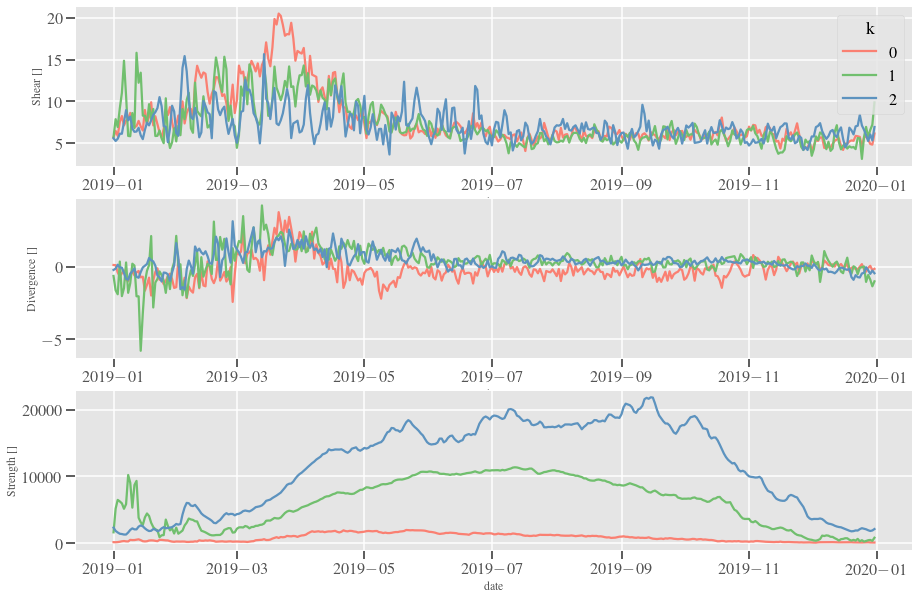

In [192]:
# Time series plot
plt.style.use("ggplot")
#sns.set_context("talk")
#plt.figure(figsize=(12,6))
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharey=False)
#fig.suptitle('Initial Pokemon - 1st Generation')

# Time series plot with Seaborn lineplot()

sns.lineplot(ax=axes[0], x="date", y="shear", hue="k",
             data=df_timeseries, errorbar=None,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[0].set(ylabel='Shear []')
#axes[0].set_title('Horizontal veloci')

sns.lineplot(ax=axes[1], x="date", y="divu", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[1].set(ylabel='Divergence []')
# #axes[1].set_ylim((-0.1,0.1))

sns.lineplot(ax=axes[2], x="date", y="strength", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[2].set(ylabel='Strength []')
#axes[2].set_ylim((0,0.25))
#axes[2].set_title('Internal')
    
#axes[2].set_ylim((0,0.1))
# axis labels
#plt.xlabel("Date", size=14)
#plt.ylabel("Daily New Cases", size=14)
# save image as PNG file

#df_magnitude
plt.savefig(savepath+'dynamics_ts.png', dpi = 600, bbox_inches="tight")


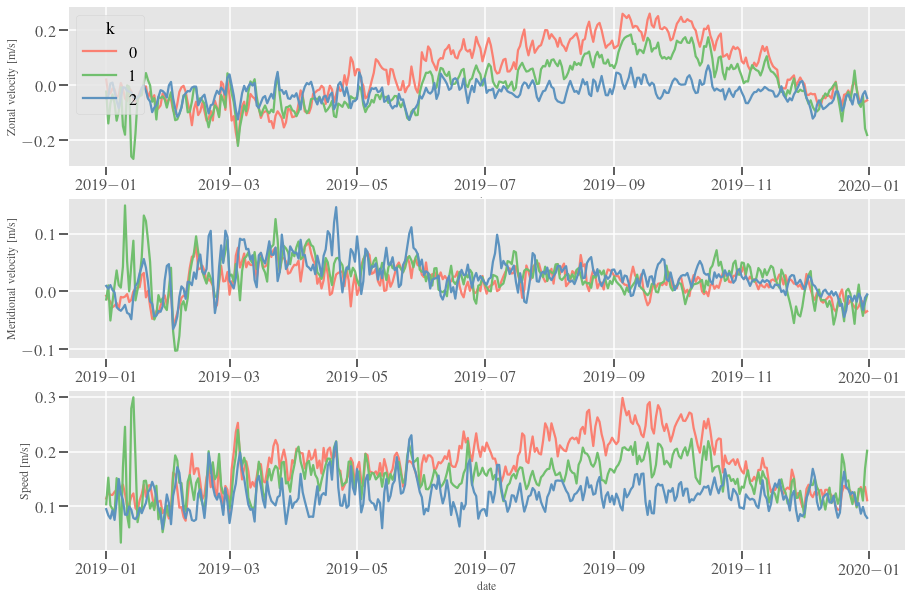

In [193]:
# Velocity time series plot
plt.style.use("ggplot")
#sns.set_context("talk")
#plt.figure(figsize=(12,6))
fig, axes = plt.subplots(5, 1, figsize=(15, 10), sharey=False)
#fig.suptitle('Initial Pokemon - 1st Generation')

# Time series plot with Seaborn lineplot()

sns.lineplot(ax=axes[0], x="date", y="uvel", hue="k",
             data=df_timeseries, errorbar=None,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[0].set(ylabel='Zonal velocity [m/s]')
#axes[0].set_title('Horizontal veloci')

sns.lineplot(ax=axes[1], x="date", y="vvel", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[1].set(ylabel='Meridional velocity [m/s]')
# #axes[1].set_ylim((-0.1,0.1))

sns.lineplot(ax=axes[2], x="date", y="vel", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[2].set(ylabel='Speed [m/s]')

sns.lineplot(ax=axes[2], x="date", y="uatm", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[3].set(ylabel='uatm [m/s]')

sns.lineplot(ax=axes[2], x="date", y="vatm", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
axes[4].set(ylabel='vatm [m/s]')
#axes[2].set_ylim((0,0.25))
#axes[2].set_title('Internal')
    
#axes[2].set_ylim((0,0.1))
# axis labels
#plt.xlabel("Date", size=14)
#plt.ylabel("Daily New Cases", size=14)
# save image as PNG file

#df_magnitude
plt.savefig(savepath+'velocity_ts.png', dpi = 600, bbox_inches="tight")


# Melting

<Figure size 1279.68x720 with 0 Axes>

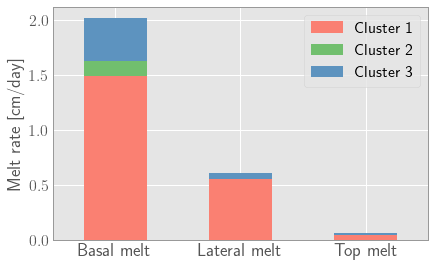

In [45]:
# Melting
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})


fig = plt.figure(figsize=(13.33,7.5), dpi=96)
#plt.style.use("fivethirtyeight")


# create DataFrame
df_melt = pd.DataFrame({'k': df["k"].values,
                             "date": df["date"].values,
                             "meltt": df["meltt"].values,
                             "meltl": df["meltl"].values,
                             "meltb": df["meltb"].values,
                            })
                             
#df_magnitude["strair"] = np.sqrt(np.square(df["strairx"])+np.square(df["strairy"]))
#df_magnitude["strocn"] = np.sqrt(np.square(df["strairx"])+np.square(df["strairy"]))


df_grouped = df_melt[["meltb", "meltl", "meltt", "k"]].groupby('k').mean(numeric_only=True)
#df_grouped["dafsd_latm"] = df_grouped["dafsd_latm"]*100#.values*(10^5)
#df_grouped["dafsd_latg"] = df_grouped["dafsd_latg"]*10000


df_plot = pd.DataFrame({'1': df_grouped.iloc[0,:].values,
                        '2': df_grouped.iloc[1,:].values,
                        '3': df_grouped.iloc[2,:].values},
                        index=['Basal melt', 'Lateral melt', 'Top melt'])
 
 
# create stacked bar chart for monthly temperatures

#fig, axes = plt.subplots(1, 1, figsize=(9, 6), sharey=True)
ax = df_plot.plot(kind='bar', stacked=True, 
             color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)],
             linewidth=2)
 
# labels for x & y axis
#plt.xlabel('Floe size mechanisms')
#ax.set_facecolor((1.0, 1.0, 1.0))
plt.legend(['Cluster 1','Cluster 2','Cluster 3'], fontsize=16)
plt.xticks(rotation = 0, fontsize=18)
plt.ylabel('Melt rate [cm/day]', fontsize=18)

 
# title of plot
#plt.title('Monthly Temperatures in a year')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'melt_bar_paper.png', dpi = 1000, bbox_inches="tight", transparent=False)
#import matplotlib2tikz
#matplotlib2tikz.save(savepath+'melt_bar.tex')


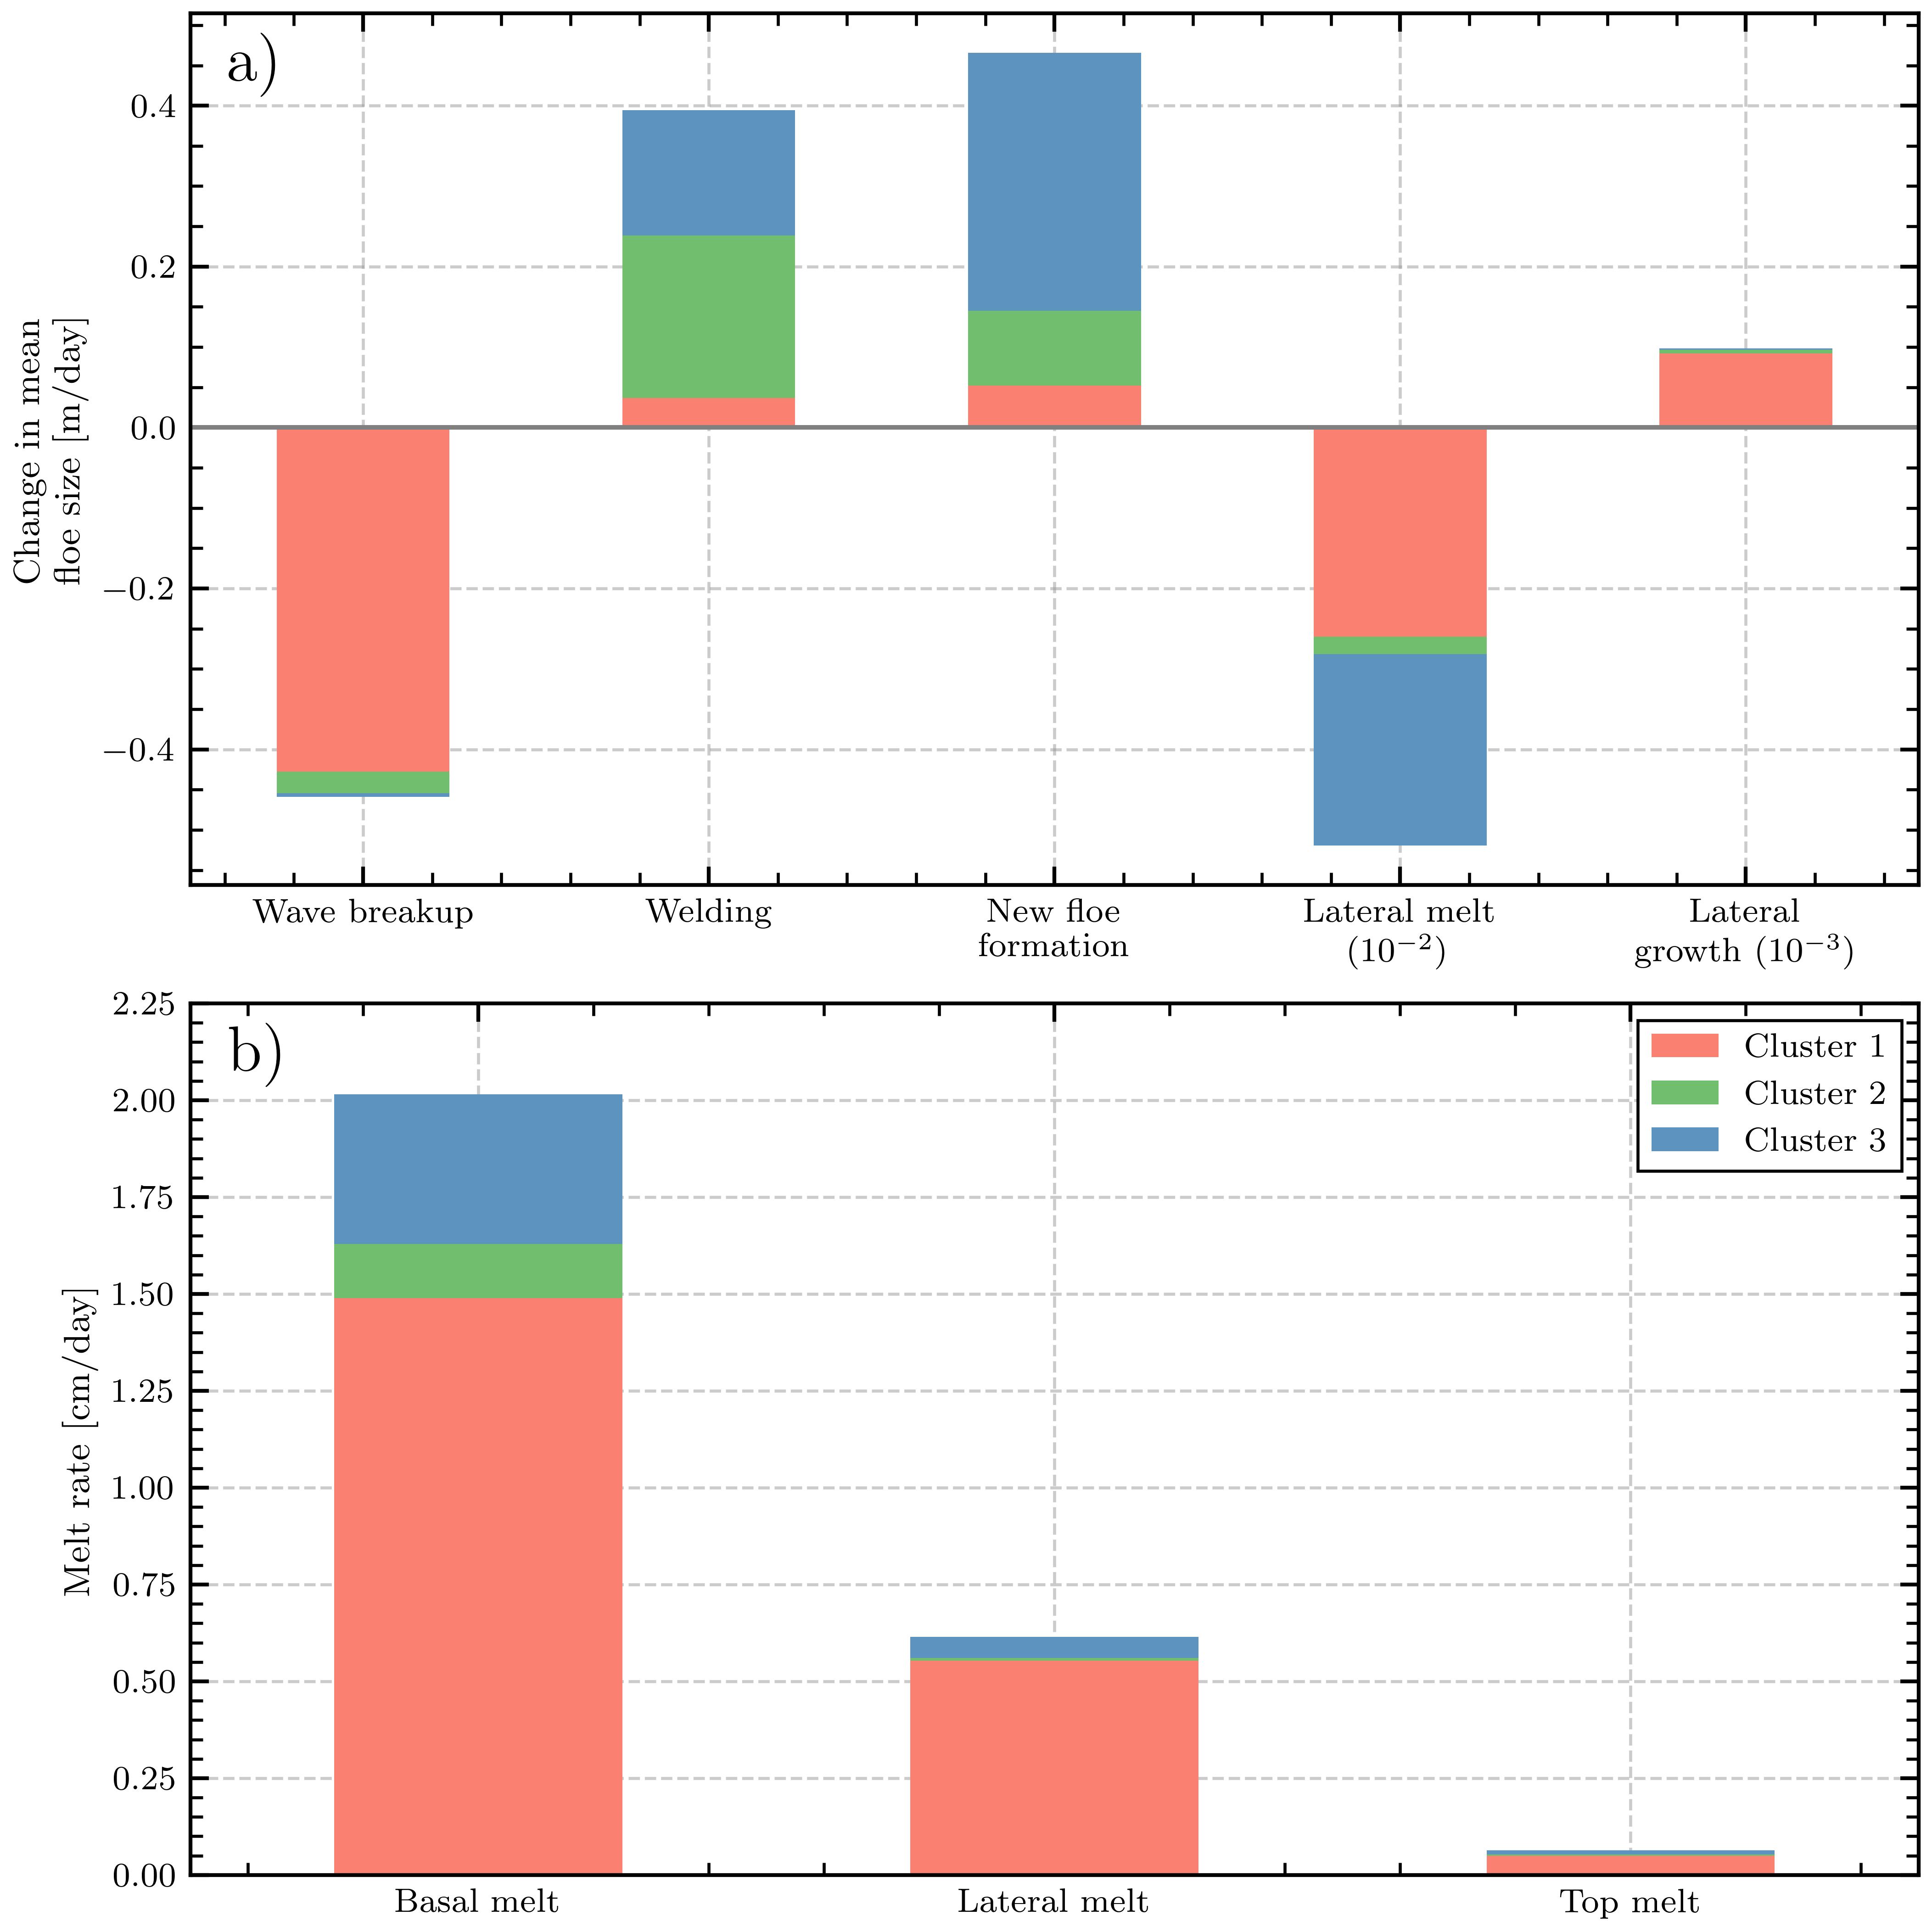

In [45]:
df_fsd = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/analysis_fsd_raw_'+str(year)+'.csv')
df_kmeans = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/kmeans_'+str(year)+'.csv')
df_fsd['k'] = df_kmeans['k']
unique_dates = df_fsd['date'].unique()
df.groupby('k').describe()

rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
# sns.set_context("paper")
# font_size = 16
# mpl.rcParams.update({'font.size': font_size})

# mpl.rc('xtick', labelsize=14) 
# mpl.rc('ytick', labelsize=14) 
# mpl.rcParams["axes.edgecolor"] = [0.6, 0.6, 0.6]
# mpl.rcParams["axes.linewidth"] = 1.0
# #mpl.rcParams["axes.set_facecolor"] = [1.0, 1.0, 1.0]

# plt.style.use("ggplot")

textwidth = 3.31314
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio

plt.style.use("seaborn")

import scienceplots
plt.style.use('default')
plt.style.use(['science','ieee', 'grid'])
sns.set_context("paper")
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
font_size = 14
mpl.rcParams.update({'font.size': font_size})
mpl.rcParams.update({"axes.grid" : True, "grid.color": [0.6, 0.6, 0.6]})



fig, axes = plt.subplot_mosaic([['a)'], ['b)']], layout='constrained', sharex=False, figsize=(7,7))

#import scienceplots
#plt.style.use(['science', 'pgf'])


# Get the FSD processes into a plotting dataframe
df_grouped = df_fsd[["dafsd_wave", "dafsd_weld", "dafsd_newi", "dafsd_latm", "dafsd_latg", "k"]].groupby('k').mean(numeric_only=True)
df_grouped["dafsd_latm"] = df_grouped["dafsd_latm"]*100#.values*(10^5)
df_grouped["dafsd_latg"] = df_grouped["dafsd_latg"]*10000
# , "dafsd_latm", "dafsd_latg"
xtick_labels_fsd = ['Wave breakup', 'Welding', 'New floe\nformation', 'Lateral melt\n($10^{-2}$)', 'Lateral\ngrowth ($10^{-3}$)']
df_plot_fsd = pd.DataFrame({'1': df_grouped.iloc[0,:].values,
                        '2': df_grouped.iloc[1,:].values,
                        '3': df_grouped.iloc[2,:].values},
                        index=xtick_labels_fsd)


# Get the melting processes into a plotting dataframe
df_melt = pd.DataFrame({'k': df["k"].values,
                             "date": df["date"].values,
                             "meltt": df["meltt"].values,
                             "meltl": df["meltl"].values,
                             "meltb": df["meltb"].values,
                            })
df_grouped = df_melt[["meltb", "meltl", "meltt", "k"]].groupby('k').mean(numeric_only=True)
df_plot_melt = pd.DataFrame({'1': df_grouped.iloc[0,:].values,
                        '2': df_grouped.iloc[1,:].values,
                        '3': df_grouped.iloc[2,:].values},
                        index=['Basal melt', 'Lateral melt', 'Top melt'])

    
for label, ax in axes.items():
    if label == 'a)':
        # create stacked bar chart for monthly temperatures
        df_plot_fsd.plot(ax = ax, kind='bar', stacked=True, 
                     color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)],
                     legend=None)
        ax.set_ylabel('Change in mean\nfloe size [m/day]')
        ax.set_xticklabels(labels=xtick_labels_fsd, rotation=0)
        ax.axhline(y = 0.0, color = 'gray', linestyle = '-')

        
    elif label == 'b)':
        df_plot_melt.plot(ax = ax, kind='bar', stacked=True, 
                     color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)],
                     linewidth=2)
        ax.set_ylim((0,2.25))
        plt.legend(['Cluster 1','Cluster 2','Cluster 3'], fancybox=False, edgecolor="black")
        plt.xticks(rotation = 0)
        plt.ylabel('Melt rate [cm/day]')
   # ax.set_facecolor([0.2, 0.2, 0.2])
    
    add_subplot_label(fig, label)
#    ax.patch.set_facecolor('white')

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'dafsd_melt_bar.png', dpi = 1000, bbox_inches="tight", transparent=True)
plt.savefig(savepath+'dafsd_melt_bar.pdf') #, transparent=True)

In [50]:
#axes.set_facecolor('white')
#mpl.rcParams

In [177]:
# Timeseries data
# df_timeseries = df_melt.groupby(['date', 'k']).mean(numeric_only=True)
# #df_timeseries
# df_timeseries['meltb_14day_ave'] = df_timeseries.meltb.rolling(7).mean().shift(-3)
# df_timeseries['meltl_14day_ave'] = df_timeseries.meltl.rolling(7).mean().shift(-3)
# df_timeseries['meltt_14day_ave'] = df_timeseries.meltt.rolling(7).mean().shift(-3)

df_melt['date'] = pd.to_datetime(df_melt['date'], format="%Y-%m-%d")
df_timeseries = df_melt.groupby(['date', 'k']).rolling(14).mean(numeric_only=True)


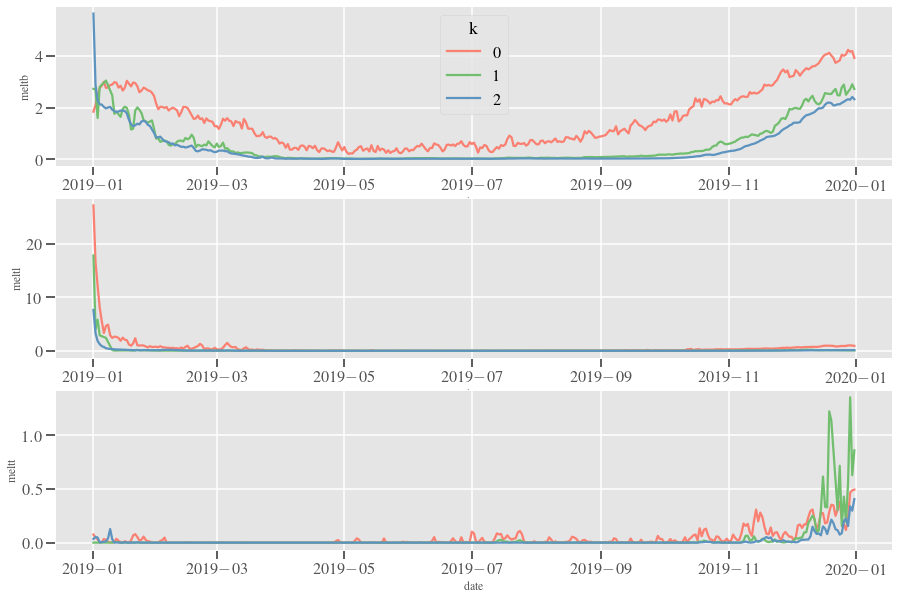

In [178]:
# Time series plot
plt.style.use("ggplot")
#sns.set_context("talk")
# set figure size
#plt.figure(figsize=(12,6))
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharey=False)
#fig.suptitle('Initial Pokemon - 1st Generation')


# Time series plot with Seaborn lineplot()

sns.lineplot(ax=axes[0], x="date", y="meltb", hue="k",
             data=df_timeseries, errorbar=None,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#plt.ylim((0,10))
#axes[0].set_title('Horizontal veloci')

sns.lineplot(ax=axes[1], x="date", y="meltl", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#axes[1].set_ylim((-0.1,0.1))

sns.lineplot(ax=axes[2], x="date", y="meltt", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])


plt.savefig(savepath+'melt_ts.png', dpi = 600, bbox_inches="tight")


## Ice formation

## Ice formation

<Figure size 1279.68x720 with 0 Axes>

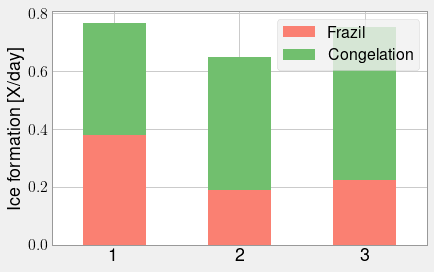

In [15]:
# Frazil vs congelation
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
mpl.rcParams.update({'font.size': 22})

mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 

fig = plt.figure(figsize=(13.33,7.5), dpi=96)
plt.style.use("fivethirtyeight")
mpl.rcParams["axes.edgecolor"] = [0.6, 0.6, 0.6]
mpl.rcParams["axes.linewidth"] = 1.0

# create DataFrame
df_frazil = pd.DataFrame({'k': df["k"].values,
                             "date": df["date"].values,
                             "frazil": df["frazil"].values,
                             "congel": df["congel"].values,
                            })
                             

df_grouped = df_melt[["frazil", "congel", "k"]].groupby('k').mean(numeric_only=True)

df_plot = pd.DataFrame({'Frazil': df_grouped.iloc[:,0].values,
                        'Congelation': df_grouped.iloc[:,1].values},
                        index=['1', '2', '3'])
 
 
# create stacked bar chart for monthly temperatures

#fig, axes = plt.subplots(1, 1, figsize=(9, 6), sharey=True)
ax = df_plot.plot(kind='bar', stacked=True, 
             color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)],
             linewidth=2)
 
# labels for x & y axis
#plt.xlabel('Floe size mechanisms')
ax.set_facecolor((1.0, 1.0, 1.0))
plt.legend(['Frazil','Congelation'], fontsize=16)
plt.xticks(rotation = 0, fontsize=18)
plt.ylabel('Ice formation [cm/day]', fontsize=18)


savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'frazil_bar.png', dpi = 1000, bbox_inches="tight", transparent=False)
#import matplotlib2tikz
#matplotlib2tikz.save(savepath+'melt_bar.tex')


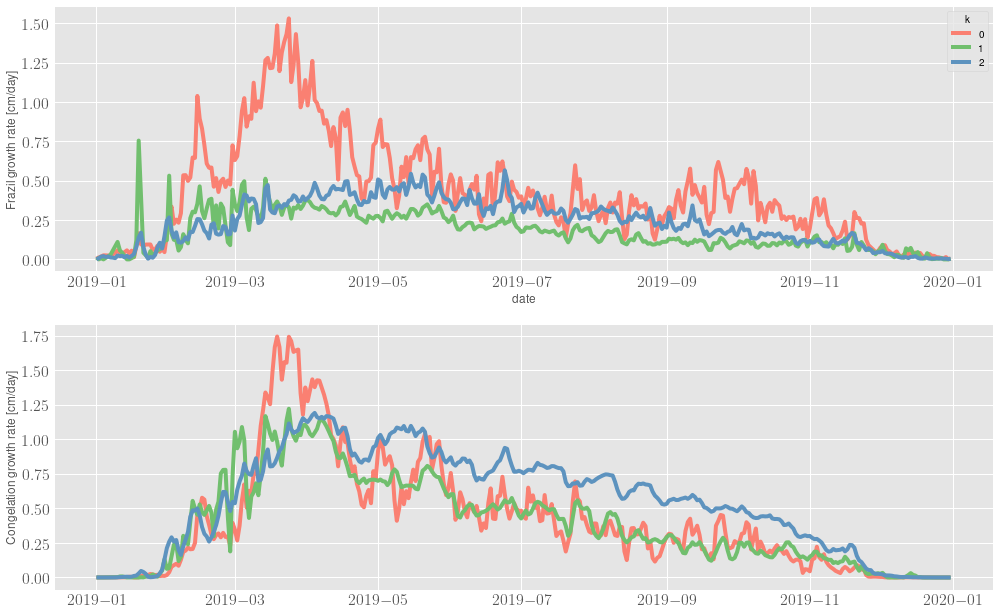

In [26]:
# Time series plot
df_frazil['date'] = pd.to_datetime(df_frazil['date'], format="%Y-%m-%d")
df_timeseries = df_frazil.groupby(['date', 'k']).rolling(14).mean(numeric_only=True)

plt.style.use("ggplot")
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharey=False)

sns.lineplot(ax=axes[0], x="date", y="frazil", hue="k",
             data=df_timeseries, errorbar=None,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#plt.ylim((0,10))
axes[0].set_ylabel("Frazil growth rate [cm/day]")

sns.lineplot(ax=axes[1], x="date", y="congel", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#axes[1].set_ylim((-0.1,0.1))
axes[1].set_ylabel("Congelation growth rate [cm/day]")
plt.xlabel("")

plt.savefig(savepath+'frazil_ts.png', dpi = 600, bbox_inches="tight")


# Pancake cycle

In [3]:
year = 2019
df_dafsd = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/analysis_fsd_raw_'+str(year)+'.csv')
df_raw = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/raw_'+str(year)+'.csv')
df_kmean = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/kmeans_'+str(year)+'.csv')

# create DataFrame
df_pancake = pd.DataFrame({'k': df["k"].values,
                         "date": df["date"].values,
                         "frazil": df["frazil"].values,
                         "congel": df["congel"].values,
                         "pancake": df_dafsd["pancake"].values,
                         "wave_sig_ht": df["wave_sig_ht"].values,
                         "daidtd": df["daidtd"].values,
                         "daidtt": df["daidtt"].values,
                         "dagedtd": df["dagedtd"].values,
                         "dagedtt": df["dagedtt"].values,
                         "divu": df["divu"].values,
                         "uatm": df["uatm"].values,
                         "vatm": df["vatm"].values,
                         "uvel": df["uvel"].values,
                         "vvel": df["vvel"].values,
                         "dafsd_wave": df_dafsd["dafsd_wave"].values,
                         "dafsd_latg": df_dafsd["dafsd_latg"].values,
                         "dafsd_latm": df_dafsd["dafsd_latm"].values,
                         "dafsd_weld": df_dafsd["dafsd_weld"].values,
                         "dafsd_newi": df_dafsd["dafsd_newi"].values,
                         "aice": df_raw["aice"].values,
                         "fsdrad": df_raw["fsdrad"].values,
                         "iage": df_raw["iage"].values
                            })
                             
del df_dafsd, df_raw, df_kmean

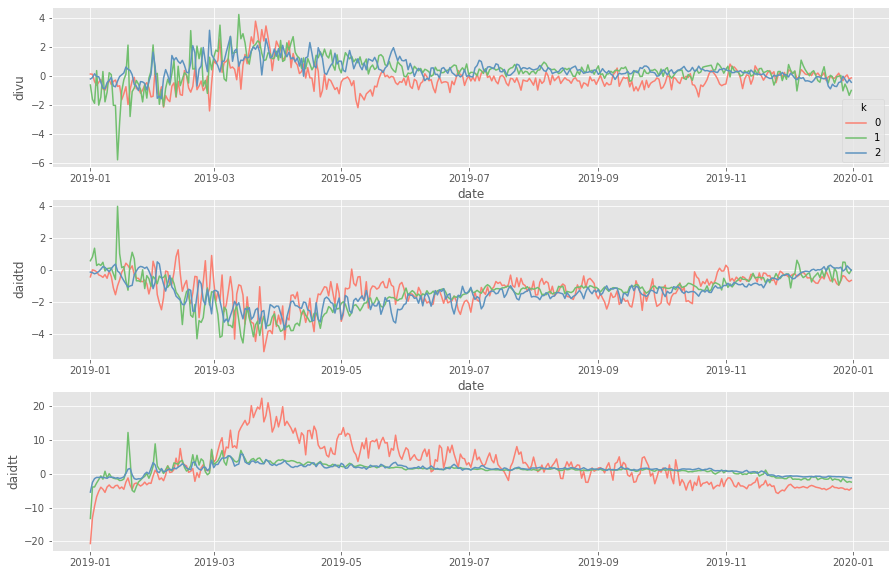

In [11]:
# Time series plot
df_pancake['date'] = pd.to_datetime(df_pancake['date'], format="%Y-%m-%d")
df_timeseries = df_pancake.groupby(['date', 'k']).rolling(7).mean(numeric_only=True)

plt.style.use("ggplot")
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharey=False)

sns.lineplot(ax=axes[0], x="date", y="divu", hue="k",
             data=df_timeseries, errorbar=None,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#plt.ylim((0,10))
#axes[0].set_ylabel("Frazil growth rate [cm/day]")

sns.lineplot(ax=axes[1], x="date", y="daidtd", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
# #axes[1].set_ylim((-0.1,0.1))
# #axes[1].set_ylabel("Congelation growth rate [cm/day]")


sns.lineplot(ax=axes[2], x="date", y="daidtt", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
# #axes[1].set_ylim((-0.1,0.1))
# #axes[1].set_ylabel("Congelation growth rate [cm/day]")


plt.xlabel("")
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'pancake_cycle_ts1.png', dpi = 600, bbox_inches="tight")


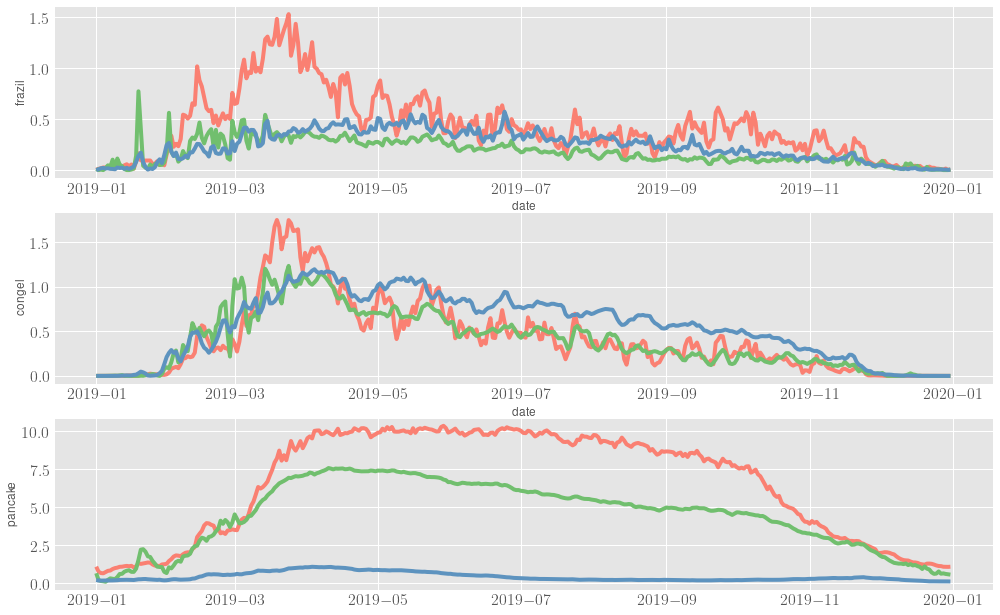

In [21]:
df_pancake['date'] = pd.to_datetime(df_pancake['date'], format="%Y-%m-%d")
df_timeseries = df_pancake.groupby(['date', 'k']).rolling(7).mean(numeric_only=True)

plt.style.use("ggplot")
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharey=False)

sns.lineplot(ax=axes[0], x="date", y="frazil", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
# #axes[1].set_ylim((-0.1,0.1))
# #axes[1].set_ylabel("Congelation growth rate [cm/day]")


sns.lineplot(ax=axes[1], x="date", y="congel", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
# #axes[1].set_ylim((-0.1,0.1))
# #axes[1].set_ylabel("Congelation growth rate [cm/day]")

sns.lineplot(ax=axes[2], x="date", y="pancake", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
# #axes[1].set_ylim((-0.1,0.1))
# #axes[1].set_ylabel("Congelation growth rate [cm/day]")

plt.xlabel("")
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'pancake_cycle_ts2.png', dpi = 600, bbox_inches="tight")


In [5]:
#df_timeseries = df_pancake.groupby(['date']).rolling(7).mean(numeric_only=True)
df_pancake = df_pancake.loc[df_pancake['k'] == 0]
df_miz_ts = pd.DataFrame({'k': df_pancake["k"].values,
                         "date": df_pancake["date"].values,
                         "frazil": df_pancake["frazil"].values,
                         "congel": df_pancake["congel"].values,
                         "pancake": df_pancake["pancake"].values,
                         "wave_sig_ht": df_pancake["wave_sig_ht"].values,
                         "daidtd": df_pancake["daidtd"].values,
                         "daidtt": df_pancake["daidtt"].values,
                         "divu": df_pancake["divu"].values,
                         "uatm": df_pancake["uatm"].values,
                         "vatm": df_pancake["vatm"].values,
                         "uvel": df_pancake["uvel"].values,
                         "vvel": df_pancake["vvel"].values,
                         "dafsd_wave": df_pancake["dafsd_wave"].values,
                         "dafsd_latg": df_pancake["dafsd_latg"].values,
                         "dafsd_latm": df_pancake["dafsd_latm"].values,
                         "dafsd_weld": df_pancake["dafsd_weld"].values,
                         "dafsd_newi": df_pancake["dafsd_newi"].values,
                         "aice": df_pancake["dafsd_newi"].values,
                         "fsdrad": df_pancake["fsdrad"].values,
                         "iage": df_pancake["iage"].values
                            })
                             

In [7]:
# Calculate MIZ area
filename = '/g/data/ia40/sea-ice-classification/kmean_'+str(year)+'.nc'
ds = xr.open_dataset(filename)

miz_cluster = 0 # What cluster does the MIZ correspond with?

# Initialise arrays
n_days = 365
SIE_MIZ = np.empty((n_days))
SIE_total = np.empty((n_days))


day_vec = range(0,n_days,1)

# Circumpolar for each day
for day_idx in day_vec:
    progressBar = "\rProgress: " + ProgressBar(n_days, day_idx+1, 20, '#', '.')
    ShowBar(progressBar)
    SIE_MIZ[day_idx] = np.multiply(ds['tarea'][:,:].data, ds['k'][day_idx,:,:].data == miz_cluster).sum()
    SIE_total[day_idx] = np.multiply(ds['tarea'][:,:].data, ds['aice'][day_idx,:,:].data > 0.15).sum()
print('Done!')

df_miz_ts['date'] = pd.to_datetime(df_miz_ts['date'], format="%Y-%m-%d")
#df_timeseries_MIZ = df_miz_ts.groupby(['date']).rolling(7).mean(numeric_only=True)
df_timeseries_MIZ = df_miz_ts.groupby(['date']).mean()
df_timeseries_MIZ['MIZ_extent'] = SIE_MIZ

Progress: [####################] 100% 
Done!


<AxesSubplot:xlabel='date', ylabel='frazil'>

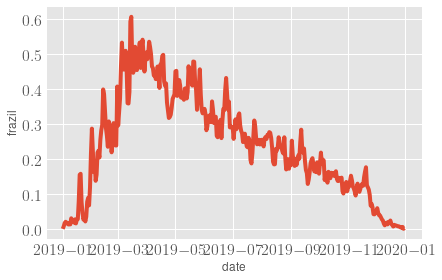

In [21]:
sns.lineplot(x="date", y="frazil",
             data=df_timeseries_MIZ, 
             errorbar=None, legend=False)

In [8]:
df_timeseries_MIZ['dafsd_wave'] = cyclic_moving_av(np.array(df_timeseries_MIZ['dafsd_wave']), n = 15)
df_timeseries_MIZ['dafsd_weld'] = cyclic_moving_av(np.array(df_timeseries_MIZ['dafsd_weld']), n = 15)
df_timeseries_MIZ['dafsd_newi'] = cyclic_moving_av(np.array(df_timeseries_MIZ['dafsd_newi']), n = 15)

df_timeseries_MIZ['MIZ_extent'] = cyclic_moving_av(np.array(df_timeseries_MIZ['MIZ_extent']))*10**(-12)
#df_timeseries_MIZ['MIZ_extent'].rolling(30).mean(numeric_only=True)

#dMIZ = np.zeros(len(df_timeseries_MIZ['MIZ_extent']))
#dMIZ[1:] = df_timeseries_MIZ['MIZ_extent'][1:-1] - df_timeseries_MIZ['MIZ_extent'][0:-2]
df_timeseries_MIZ['dMIZ_extentdt'] = df_timeseries_MIZ['MIZ_extent'].diff()
df_timeseries_MIZ['dMIZ_extentdt'] = cyclic_moving_av(np.array(df_timeseries_MIZ['dMIZ_extentdt']))#*10**(-12)
#df_timeseries_MIZ['dMIZ_extentdt'].rolling(7).mean(numeric_only=True)


df_timeseries_MIZ['divu'] = cyclic_moving_av(np.array(df_timeseries_MIZ['divu']))
df_timeseries_MIZ['neg_daidtd'] = -cyclic_moving_av(np.array(df_timeseries_MIZ['daidtd']))
df_timeseries_MIZ['daidtt'] = cyclic_moving_av(np.array(df_timeseries_MIZ['daidtt']))
df_timeseries_MIZ['frazil'] = cyclic_moving_av(np.array(df_timeseries_MIZ['frazil']))

df_timeseries_MIZ['fsdrad_ma'] = cyclic_moving_av(np.array(df_timeseries_MIZ['fsdrad']))
df_timeseries_MIZ['iage_ma'] = cyclic_moving_av(np.array(df_timeseries_MIZ['iage']))
df_timeseries_MIZ['aice_ma'] = cyclic_moving_av(np.array(df_timeseries_MIZ['aice'])*100)

In [9]:
df_timeseries_MIZ['divu_norm'] = df_timeseries_MIZ['divu']/(df_timeseries_MIZ['divu'].abs().max())
df_timeseries_MIZ['neg_daidtd_norm'] = df_timeseries_MIZ['neg_daidtd']/(df_timeseries_MIZ['neg_daidtd'].abs().max())
df_timeseries_MIZ['daidtt_norm'] = df_timeseries_MIZ['daidtt']/(df_timeseries_MIZ['daidtt'].abs().max())
df_timeseries_MIZ['frazil_norm'] = df_timeseries_MIZ['frazil']/(df_timeseries_MIZ['frazil'].abs().max())

#df_timeseries_MIZ['dafsd_wave'] = df_timeseries_MIZ['dafsd_wave'].rolling(30).mean(numeric_only=True)
#df_timeseries_MIZ['dafsd_weld'] = df_timeseries_MIZ['dafsd_weld'].rolling(30).mean(numeric_only=True)
#df_timeseries_MIZ['dafsd_newi'] = df_timeseries_MIZ['dafsd_newi'].rolling(30).mean(numeric_only=True)

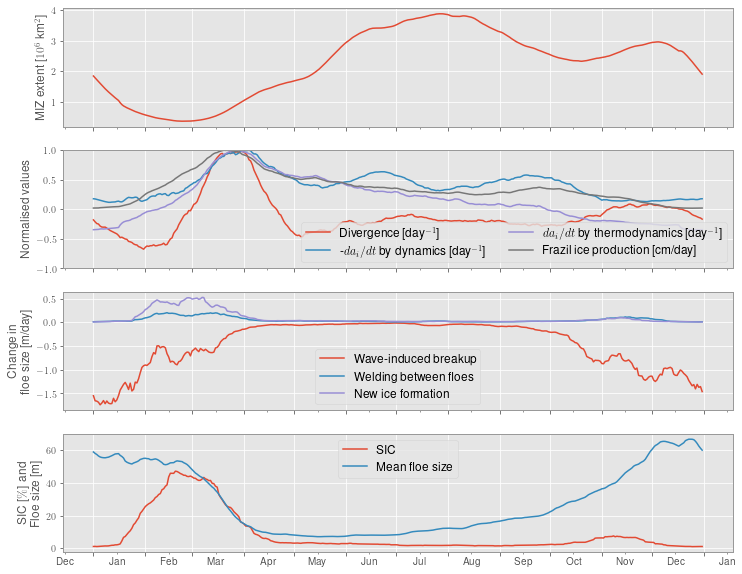

In [10]:
plt.style.use("ggplot")

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
font_size = 12
mpl.rcParams.update({'font.size': font_size})

mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10) 

#fig = plt.figure(figsize=(13.33,7.5), dpi=96)
#plt.style.use("fivethirtyeight")
mpl.rcParams["axes.edgecolor"] = [0.6, 0.6, 0.6]
mpl.rcParams["axes.linewidth"] = 1.0

month_year_formatter = mdates.DateFormatter('%b') # The "," is intentional.



fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharey=False, sharex=True)

monthly_locator = mdates.MonthLocator()
axes[0].xaxis.set_major_locator(mdates.MonthLocator())
axes[0].xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
axes[0].xaxis.set_major_formatter(NullFormatter())
axes[0].xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

sns.lineplot(ax=axes[0], x="date", y="MIZ_extent",
            data=df_timeseries_MIZ, errorbar=None, legend=False)
axes[0].set_ylabel('MIZ extent [$10^6$ km$^2$]')

# sns.lineplot(ax=axes[1], x="date", y="dMIZ_extentdt",
#              data=df_timeseries_MIZ, errorbar=None, legend=False)
# axes[1].set_ylabel('Change in MIZ \n extent [$10^6$ km$^2$/day]')

sns.lineplot(ax=axes[1], x="date", y="divu_norm",
             data=df_timeseries_MIZ, errorbar=None, legend=False)
sns.lineplot(ax=axes[1], x="date", y="neg_daidtd_norm",
             data=df_timeseries_MIZ, errorbar=None, legend=False)
sns.lineplot(ax=axes[1], x="date", y="daidtt_norm",
             data=df_timeseries_MIZ, errorbar=None, legend=False)
sns.lineplot(ax=axes[1], x="date", y="frazil_norm",
             data=df_timeseries_MIZ, errorbar=None, legend=False)
axes[1].set_ylabel('Normalised values')
axes[1].set_ylim((-1,1))
axes[1].legend(['Divergence [day$^{-1}$]','-$da_i/dt$ by dynamics [day$^{-1}$]','$da_i/dt$ by thermodynamics [day$^{-1}$]','Frazil ice production [cm/day]'], 
               fontsize=font_size,
               loc='lower right', ncol=2)


sns.lineplot(ax=axes[2], x="date", y="dafsd_wave",
             data=df_timeseries_MIZ, errorbar=None, legend=False)
sns.lineplot(ax=axes[2], x="date", y="dafsd_weld",
             data=df_timeseries_MIZ, errorbar=None, legend=False)
sns.lineplot(ax=axes[2], x="date", y="dafsd_newi",
             data=df_timeseries_MIZ, errorbar=None, legend=False)
axes[2].set_ylabel('Change in \nfloe size [m/day]')
axes[2].legend(['Wave-induced breakup','Welding between floes','New ice formation'], 
               fontsize=font_size)


sns.lineplot(ax=axes[3], x="date", y="aice_ma",
             data=df_timeseries_MIZ, errorbar=None, legend=False)
sns.lineplot(ax=axes[3], x="date", y="fsdrad_ma",
             data=df_timeseries_MIZ, errorbar=None, legend=False)
axes[3].set_ylabel('SIC [$\%$] and \nFloe size [m]')
axes[3].legend(['SIC','Mean floe size'], fontsize=font_size)

plt.xlabel("")

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'pancake_cycle_ts_MIZ.png', dpi = 600, bbox_inches="tight")


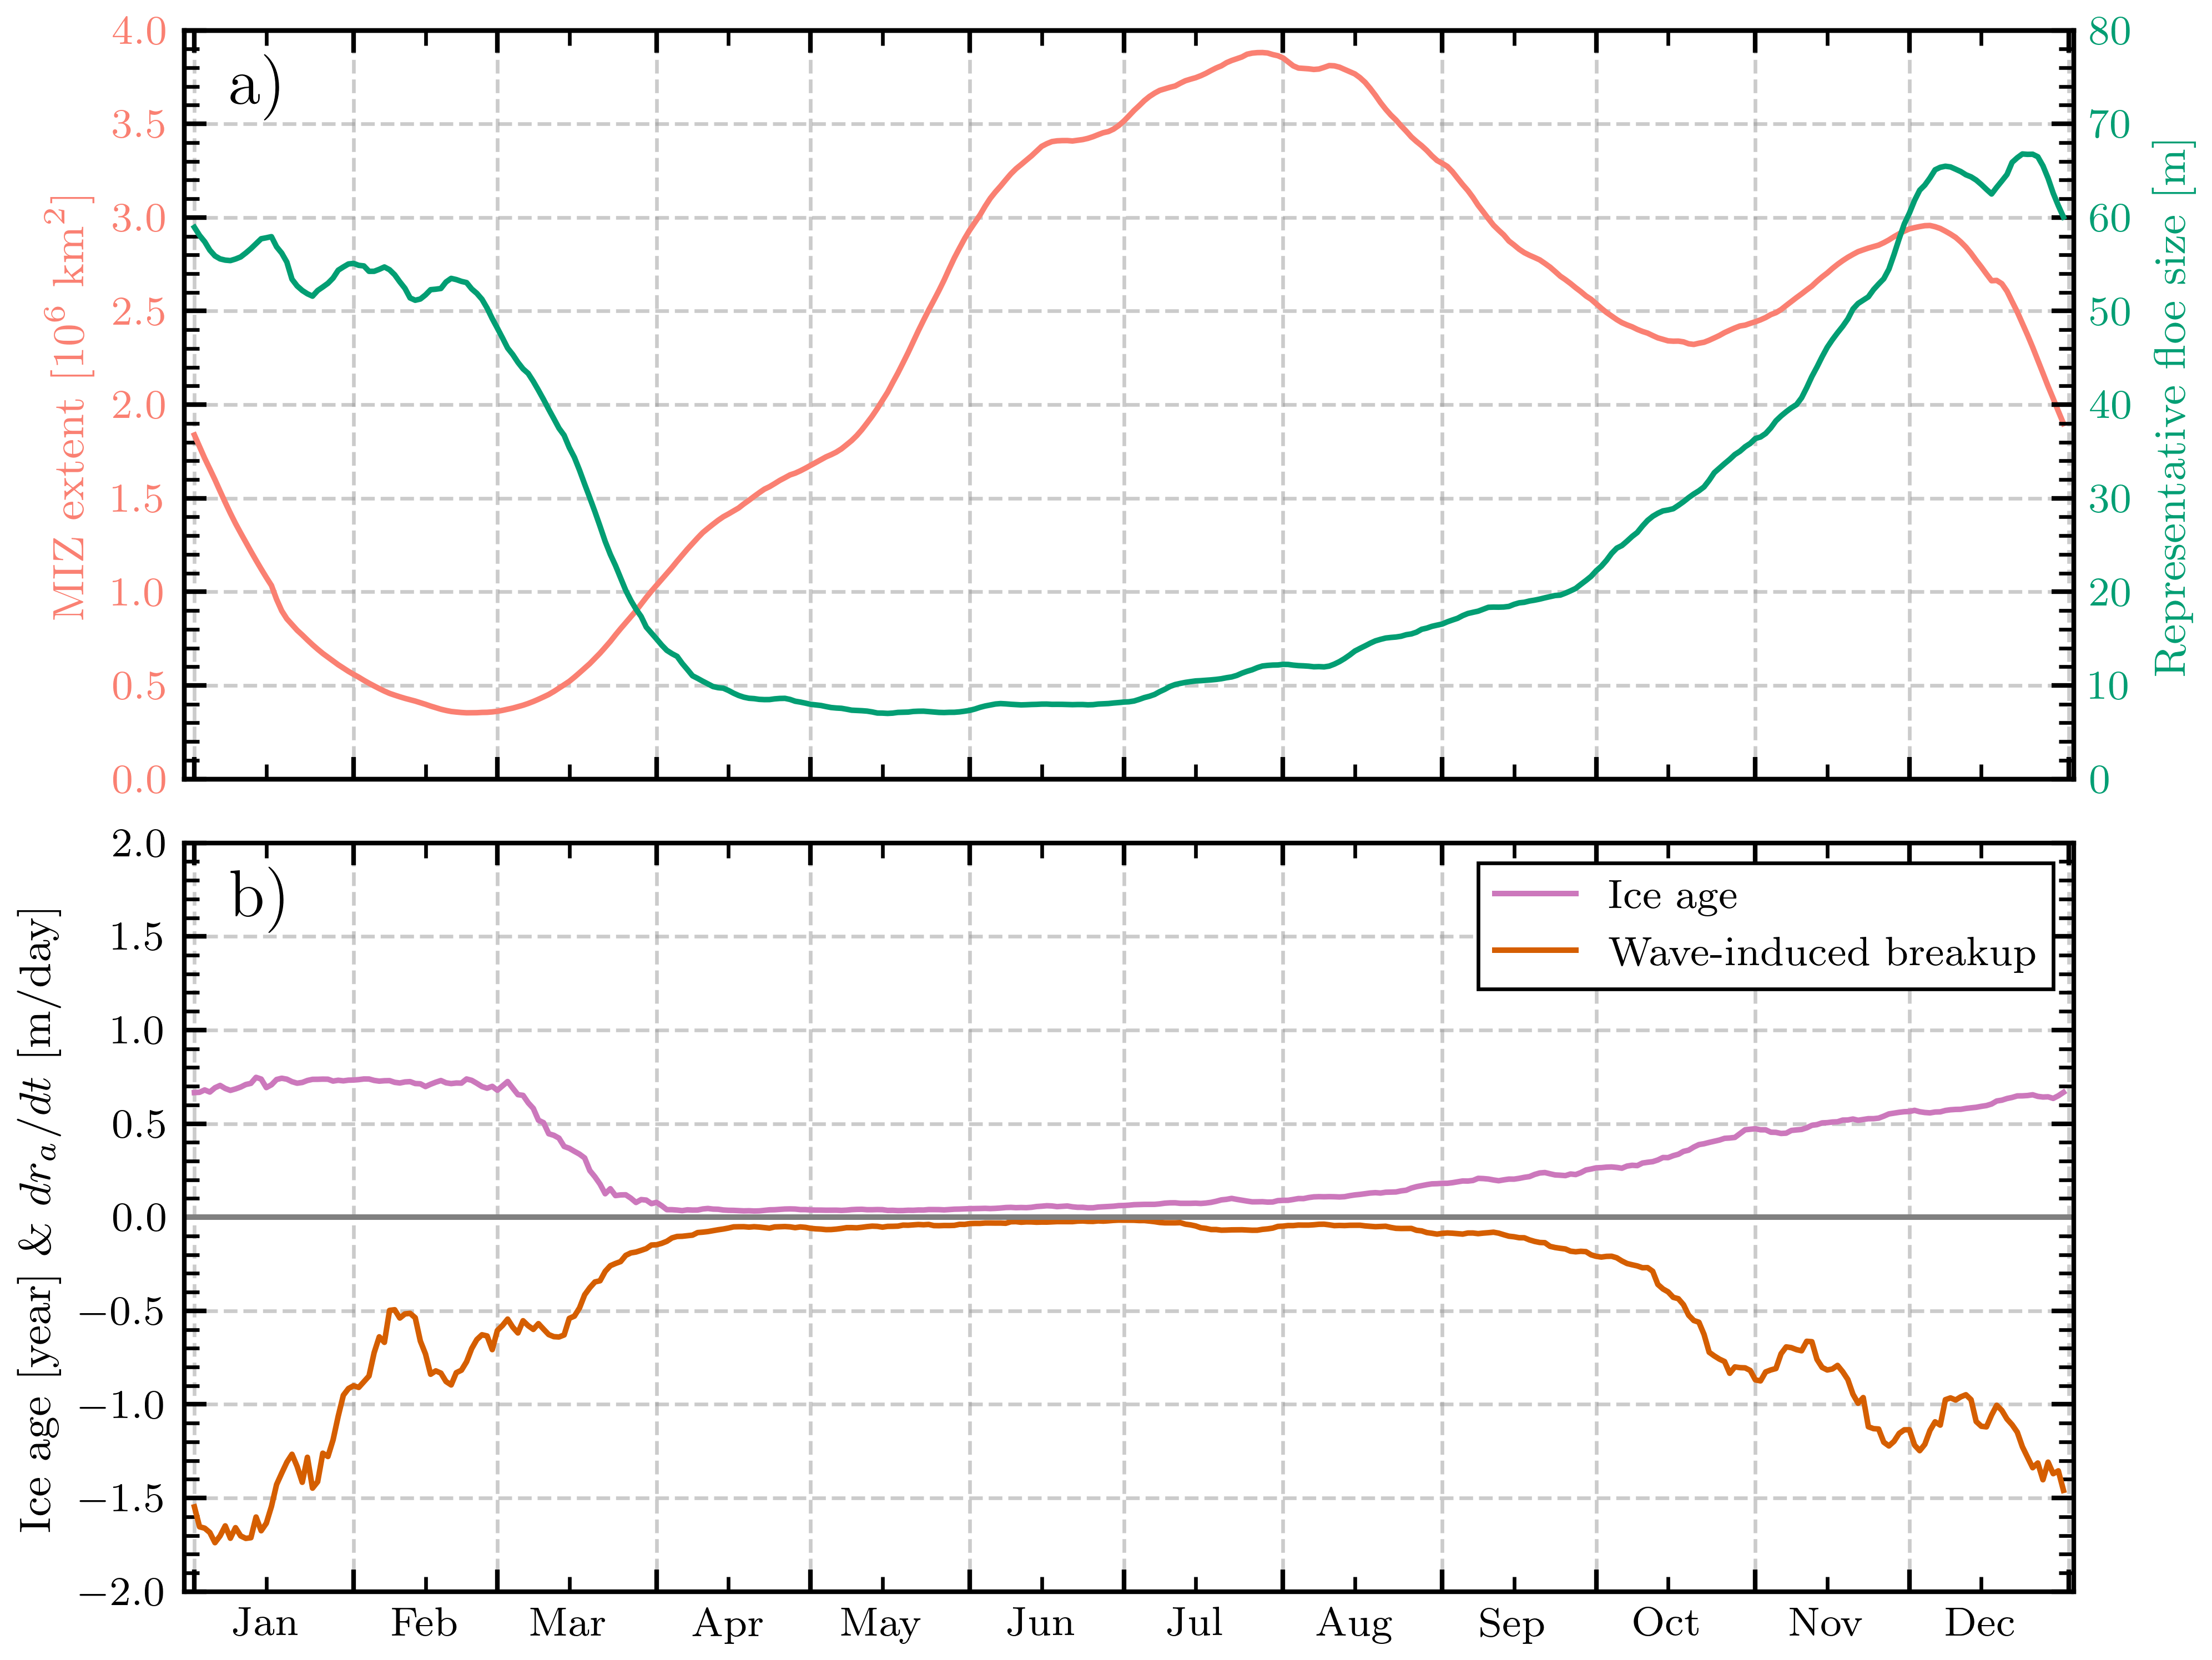

In [41]:
textwidth = 3.31314*2
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio

plt.style.use("seaborn")


COLOR_MIZ = [0.9805, 0.5000, 0.4453, 1.0]
COLOR_FSD = sns.color_palette("colorblind",15)[2]
COLOR_WAVE = sns.color_palette("colorblind",15)[3]
COLOR_IAGE = sns.color_palette("colorblind",15)[4]
#sns.color_palette("tab10")[0]

import scienceplots
plt.style.use('default')
plt.style.use(['science','ieee', 'grid'])
sns.set_context("paper")
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
font_size = 12
mpl.rcParams.update({'font.size': font_size})
mpl.rcParams.update({"axes.grid" : True, "grid.color": [0.6, 0.6, 0.6]})

#plt.style.use("seaborn")
#plt.style.use("fivethirtyeight")


#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})




# #mpl.rc('xtick', labelsize=10) 
# #mpl.rc('ytick', labelsize=10) 

#fig = plt.figure(figsize=(13.33,7.5), dpi=96)
#plt.style.use("fivethirtyeight")
#mpl.rcParams["axes.edgecolor"] = "black" #[0.6, 0.6, 0.6]
#mpl.rcParams["axes.linewidth"] = 1.0

#font_size = plot_style(plot_type="paper")



month_year_formatter = mdates.DateFormatter('%b') # The "," is intentional.




#fig, axes = plt.subplots(2, 1, figsize=(width, height), sharey=False, sharex=True)
#fig, axes = plt.subplot_mosaic([['a)','b)']], figsize=(12, 6), sharey=False, sharex=True)
fig, axes = plt.subplot_mosaic([['a)'],['b)']], figsize=(width, height), sharey=False, sharex=True,
                              layout='constrained')


for label, ax in axes.items():
    monthly_locator = mdates.MonthLocator()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    
    if label == 'a)':
        sns.lineplot(ax=ax, x="date", y="MIZ_extent",
            data=df_timeseries_MIZ, errorbar=None, legend=False,
              color=COLOR_MIZ)
        ax.set_ylabel('MIZ extent [$10^6$ km$^2$]', color=COLOR_MIZ)
        ax.tick_params(axis="y", labelcolor=COLOR_MIZ)
        ax.set_ylim((0, 4))
        
        ax2 = ax.twinx()
        sns.lineplot(ax=ax2, x="date", y="fsdrad_ma",
                      data=df_timeseries_MIZ, errorbar=None, legend=False,
                      color=COLOR_FSD)
        ax2.set_ylabel("Representative floe size [m]", color=COLOR_FSD)
        ax2.tick_params(axis="y", labelcolor=COLOR_FSD)
        ax2.grid(False)
        ax2.set_ylim((0, 80))
    elif label == 'b)':
        sns.lineplot(ax=ax, x="date", y="iage",
                     data=df_timeseries_MIZ, errorbar=None, legend=False,color=COLOR_IAGE)
        sns.lineplot(ax=ax, x="date", y="dafsd_wave",
             data=df_timeseries_MIZ, errorbar=None, legend=False, color=COLOR_WAVE)#,color=sns.color_palette("tab10")[3])
        # sns.lineplot(ax=axes[1], x="date", y="dafsd_newi",
        #              data=df_timeseries_MIZ, errorbar=None, legend=False,color=sns.color_palette("tab10")[2])
        # sns.lineplot(ax=axes[1], x="date", y="dafsd_weld",
        #              data=df_timeseries_MIZ, errorbar=None, legend=False,color=sns.color_palette("hls", 8)[-1])

        ax.set_ylabel('Ice age [year] \& $dr_{a}/dt$ [m/day]',)
        #axes[1].legend(['Wave-induced breakup','New ice formation','Welding between floes','Ice age'], 
        #               fontsize=font_size, loc='upper right', ncol=3)


        #ax.set_ylim((-df_timeseries_MIZ["dafsd_wave"].abs().max(), df_timeseries_MIZ["dafsd_wave"].abs().max()))
        ax.set_ylim((-2, 2))

        ax2 = ax#.twinx()
        
        #ax2.set_ylabel("Ice age [year]", color=sns.color_palette("tab10")[-1])
        #ax2.tick_params(axis="y", labelcolor=sns.color_palette("tab10")[-1])
        #ax2.grid(False)
        #ax2.set_ylim((-df_timeseries_MIZ["dafsd_wave"].abs().max(), df_timeseries_MIZ["dafsd_wave"].abs().max()))
        legend = ax2.legend(['Ice age','Wave-induced breakup'], fancybox=False, edgecolor="black")# loc='upper right', ncol=1, fancybox=True, edgecolor="black")
        
        ax.set_xlim((np.round(ax.get_xlim()[0]+16),np.round(ax.get_xlim()[-1]-16)))

        ax.axhline(y = 0.0, color = 'gray', linestyle = '-',alpha=1.0)
        #axes[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha= 0.5)
        #axes[1].yaxis.set_minor_locator(MultipleLocator(0.5))
        #axes[0].xaxis.set_minor_locator(MultipleLocator(15))
        ax.set_xlabel("")

        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))





#axes[0].set_ylim((0, 4.5))
#axes[0].set_facecolor((1.0, 1.0, 1.0))

#axes[0].axhline(y = 0.0, color = 'gray', linestyle = '--',alpha=0.5)
#axes[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha= 0.5)
#axes[0].yaxis.set_minor_locator(MultipleLocator(0.5))

#axes[0].xaxis.set_minor_locator(MultipleLocator(15))
#axes[0].text(0.0, 1.0, 'a)')#, #transform=ax.transAxes + trans,
#            fontsize='large', verticalalignment='top', fontfamily='serif',
#            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))


#ax2.set_yticks([0, 20, 40, 60, 80])
#ax2.set_ylim((0, 90))
#ax2.yaxis.set_minor_locator(MultipleLocator(20))




#axes[1].set_facecolor((1.0, 1.0, 1.0))

#               fontsize=font_size, 
#legend.get_frame().set_linewidth(0.5)
#legend.get_frame().set_facecolor('white')

#sns.lineplot(ax=axes[2], x="date", y="wave_sig_ht",
#             data=df_timeseries_MIZ, errorbar=None, legend=False)
# sns.lineplot(ax=axes[2], x="date", y="pancake",
#              data=df_timeseries_MIZ, errorbar=None, legend=False)



savepath = '/home/566/nd0349/notebooks/'

plt.savefig(savepath+'MIZ_evolution_ts.png', dpi = 600, bbox_inches="tight")
plt.savefig(savepath+'MIZ_evolution_ts.pdf', bbox_inches="tight")

plt.show()

In [30]:
sns.color_palette("colorblind",15)

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844)]

In [25]:
#sns.color_palette("tab10")


[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [24]:
sns.color_palette("tab10")


1.7387808224028525

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

plt.style.use("ggplot")

#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
#rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Roman']})

rc('text', usetex=True)
font_size = 12
mpl.rcParams.update({'font.size': font_size})

mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10) 
mpl.rcParams["axes.edgecolor"] = [0.6, 0.6, 0.6]
mpl.rcParams["axes.linewidth"] = 1.0

month_year_formatter = mdates.DateFormatter('%b') # The "," is intentional.

COLOR_MIZ = [0.9805, 0.5000, 0.4453, 1.0]
COLOR_FSD = sns.color_palette("tab10")[0]


fig, axs = plt.subplot_mosaic([['a)'],['b)']], figsize=(12, 6), sharey=False, sharex=True,
                              layout='constrained')



for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    
    if label == 'a)':
        sns.lineplot(ax=ax, x="date", y="MIZ_extent",
            data=df_timeseries_MIZ, errorbar=None, legend=False,
              color=COLOR_MIZ)
        ax.set_ylabel('MIZ extent [$10^6$ km$^2$]', color=COLOR_MIZ)
        ax.tick_params(axis="y", labelcolor=COLOR_MIZ)
        ax.set_ylim((0, 4.5))
        ax2 = ax.twinx()
        sns.lineplot(ax=ax2, x="date", y="fsdrad_ma",
                      data=df_timeseries_MIZ, errorbar=None, legend=False,
                      color=COLOR_FSD)
        ax2.set_ylabel("Representative floe size [m]", color=COLOR_FSD)
        ax2.tick_params(axis="y", labelcolor=COLOR_FSD)
        ax2.grid(False)
        ax2.set_ylim((0, 90))
    elif label == 'b)':
        sns.lineplot(ax=ax, x="date", y="dafsd_wave", color = sns.color_palette("tab10")[3],
             data=df_timeseries_MIZ, errorbar=None, legend=False)
        sns.lineplot(ax=ax, x="date", y="dafsd_weld",
                     data=df_timeseries_MIZ, errorbar=None, legend=False,color=sns.color_palette("hls", 8)[-1])
        sns.lineplot(ax=ax, x="date", y="dafsd_newi",
                     data=df_timeseries_MIZ, errorbar=None, legend=False,color=sns.color_palette("tab10")[2])
        ax.set_ylabel('Change in \nfloe size [m/day]')
        ax.legend(['Wave-induced breakup','Welding between floes','New ice formation'], 
                       fontsize=font_size)
        ax.set_xlabel("")
        ax.set_xlim((np.round(ax.get_xlim()[0]+16),np.round(ax.get_xlim()[-1]-16)))
        ax.set_ylim((-1.6, 1.6))
        ax.axhline(y = 0.0, color = 'gray', linestyle = '--',alpha=0.5)
        
        monthly_locator = mdates.MonthLocator()
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
        
        

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'MIZ_evolution_ts.png', dpi = 600, bbox_inches="tight")

In [103]:
ax.get_xlim()[0]

17878.8

In [36]:
sns.color_palette("tab10")
#test[0]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

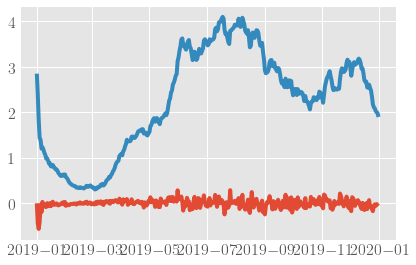

In [35]:
plt.plot(df_timeseries_MIZ['dMIZ_extentdt']/(10**6), label= 'd/dt MIZ extent')
plt.plot(df_timeseries_MIZ['MIZ_extent']/(10**6), label= 'MIZ extent')

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10.33, 5.5), sharey=False)


plt.plot(ax = axes[0], df_timeseries_MIZ['divu']/df_timeseries_MIZ['divu'].max(), label='Divergence')
plt.plot(df_timeseries_MIZ['daidtd']/df_timeseries_MIZ['daidtd'].min(), label='Negative change in SIC from thermodynamics [$\%$/day]')
plt.plot(df_timeseries_MIZ['daidtt']/df_timeseries_MIZ['daidtt'].max(), label='Change in SIC from thermodynamics [$\%$/day]')
plt.plot(df_timeseries_MIZ['frazil']/df_timeseries_MIZ['frazil'].max(), label='Frazil growth [cm/day]')
#plt.plot(df_timeseries_MIZ['congel']/df_timeseries_MIZ['congel'].max(), label='Congelation growth [cm/day]')
plt.plot(df_timeseries_MIZ['MIZ_extent']/df_timeseries_MIZ['MIZ_extent'].max(), label= 'MIZ extent')
#plt.plot(df_timeseries_MIZ['dMIZ_extentdt']/df_timeseries_MIZ['dMIZ_extentdt'].max(), label= 'd/dt MIZ extent')

ax.legend()#(handles2, labels2)
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'MIZ_evolution.png', dpi = 600, bbox_inches="tight")
plt.show()

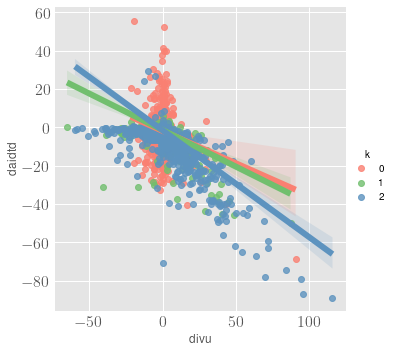

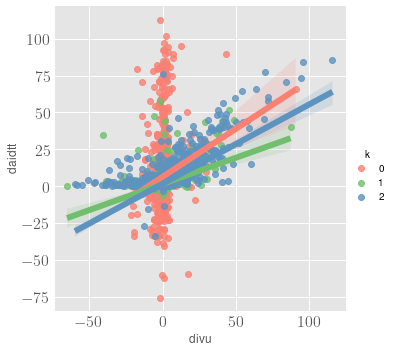

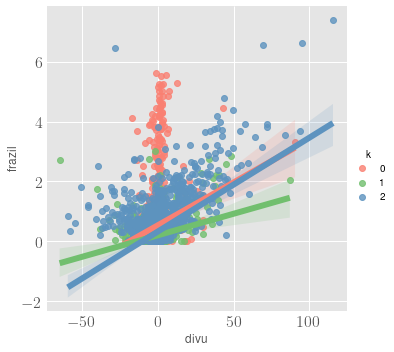

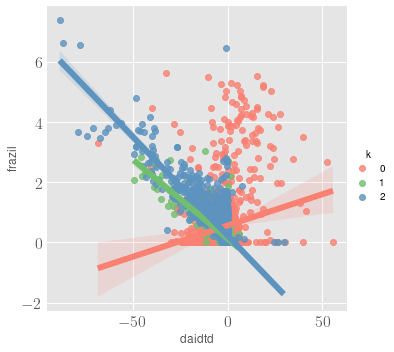

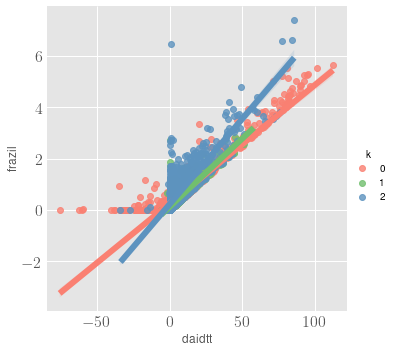

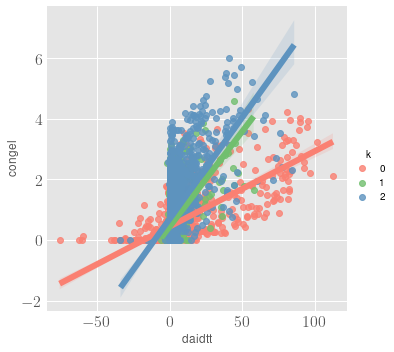

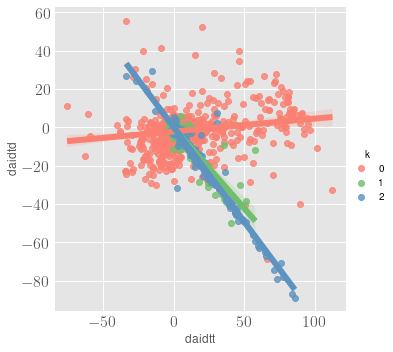

In [60]:
mask = (df_pancake['date'] > '2019-03-01') & (df_pancake['date'] <= '2019-09-01')

df_plot = df_pancake.loc[mask].sample(n=10000)

g = sns.lmplot(
    data=df_plot,
    x="divu", y="daidtd", hue="k",
    height=5,
    palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])

g = sns.lmplot(
    data=df_plot,
    x="divu", y="daidtt", hue="k",
    height=5,
    palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])

g = sns.lmplot(
    data=df_plot,
    x="divu", y="frazil", hue="k",
    height=5,
    palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])

g = sns.lmplot(
    data=df_plot,
    x="daidtd", y="frazil", hue="k",
    height=5,
    palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])

g = sns.lmplot(
    data=df_plot,
    x="daidtt", y="frazil", hue="k",
    height=5,
    palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])

g = sns.lmplot(
    data=df_plot,
    x="daidtt", y="congel", hue="k",
    height=5,
    palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])

g = sns.lmplot(
    data=df_plot,
    x="daidtt", y="daidtd", hue="k",
    height=5,
    palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])


In [54]:
#df_pancake.loc[mask]
#df_pancake['date']
mask = (df_pancake['date'] > '2019-04-01') & (df_pancake['date'] <= '2019-09-30')
mask.any()



True

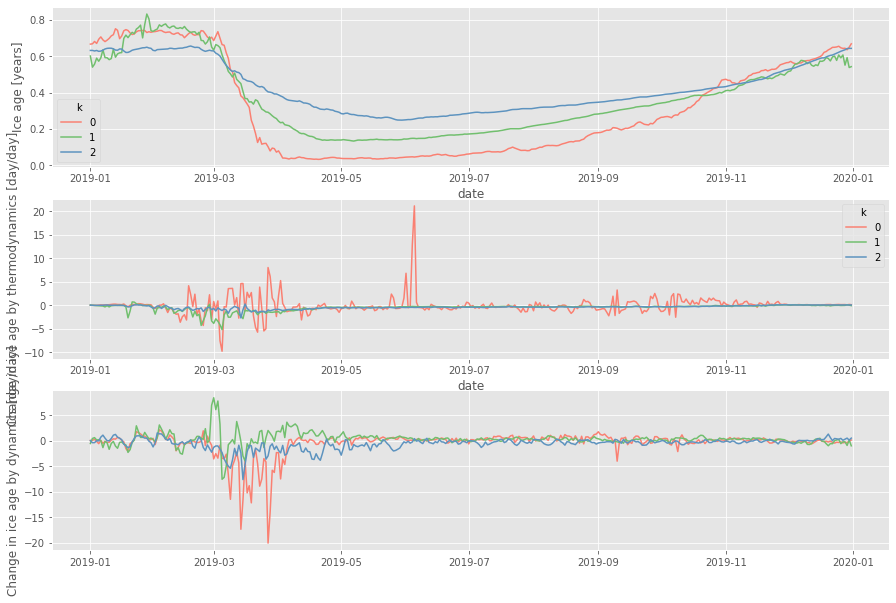

In [13]:
# Time series plot
df_pancake['date'] = pd.to_datetime(df_pancake['date'], format="%Y-%m-%d")
df_timeseries = df_pancake.groupby(['date', 'k']).rolling(7).mean(numeric_only=True)

plt.style.use("ggplot")
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharey=False)

sns.lineplot(ax=axes[0], x="date", y="iage", hue="k",
             data=df_timeseries, errorbar=None,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#plt.ylim((0,10))
axes[0].set_ylabel("Ice age [years]")

sns.lineplot(ax=axes[1], x="date", y="dagedtt", hue="k",
             data=df_timeseries, errorbar=None,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
#plt.ylim((0,10))
axes[1].set_ylabel("Change in ice age by thermodynamics [day/day]")

sns.lineplot(ax=axes[2], x="date", y="dagedtd", hue="k",
             data=df_timeseries, errorbar=None, legend=False,
             palette=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
# #axes[1].set_ylim((-0.1,0.1))
axes[2].set_ylabel("Change in ice age by dynamics [day/day]")



plt.xlabel("")
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'dagedt_ts.png', dpi = 600, bbox_inches="tight")
